# **WER/CER Analysis of Stories with Verified Scripts**

*I have now selected 10 stories and carefully corrected their scripts to serve as the ground truth for WER and CER evaluation.*

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from jiwer import wer, cer
import matplotlib.pyplot as plt

In [2]:
file_list = os.listdir()

In [3]:
# Create a list where each element is a list containing the corresponding 
# txt, pkl, and mp3 files for each PV Story
pv_list = []
for file in file_list:
    if file.endswith(".txt"): # Check if the file has a .txt extension
        txt = file
        pkl = file.replace("txt","pkl")
        mp3 = file.replace("txt","mp3")
        pv_list.append([txt, pkl, mp3])

In [4]:
# For each PV Story, load the ASR result and corresponding script,
# then calculate and store the Word Error Rate (WER) and Character Error Rate (CER)
WER = []
CER = []
for pv in pv_list:
    txt, pkl, mp3 = pv
    with open(pkl, "rb") as ASR_file:
        ASR_result = pickle.load(ASR_file)
    with open(txt, "r", encoding = 'utf-8') as script_file:
        script = script_file.read()
        
    hypothesis = ASR_result['text']
    reference = script

    WER.append(wer(reference, hypothesis))
    CER.append(cer(reference, hypothesis))

In [5]:
def quick_hist(data, title = "Histogram of List Data"):
    # Plot the histogram
    plt.hist(data, bins=10, color='skyblue', edgecolor='black')

    # Add title and axis labels
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    # Display the plot
    plt.show() 

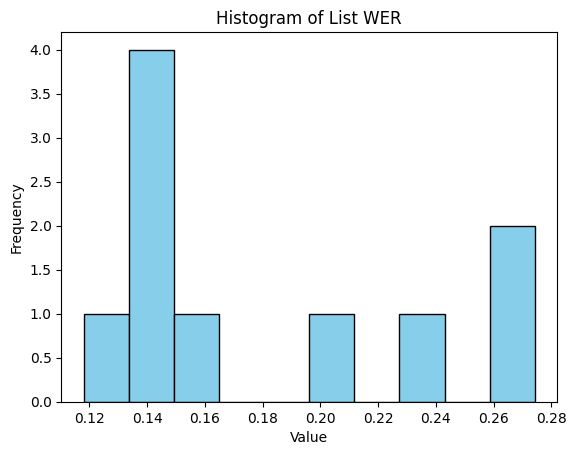

In [6]:
quick_hist(WER, "Histogram of List WER")

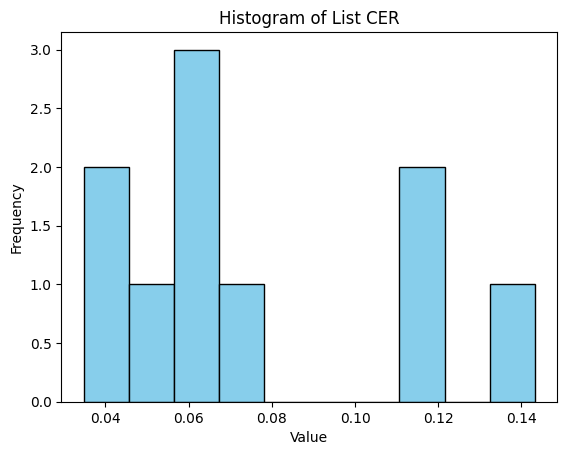

In [7]:
quick_hist(CER, "Histogram of List CER")

In [8]:
# Create a DataFrame to display PV IDs with their WER and CER values
pv_id = [pv[0][:-4] for pv in pv_list]
data = {
    'PV_ID': pv_id,
    'WER': WER,
    'CER': CER
}
df = pd.DataFrame(data)
df

PV_ID       WER       CER
0  pv0157  0.145833  0.058101
1  pv0176  0.272388  0.073803
2  pv0258  0.139024  0.034805
3  pv0262  0.202817  0.121144
4  pv0392  0.140152  0.041723
5  pv0404  0.118081  0.050000
6  pv0405  0.163317  0.064149
7  pv0685  0.274227  0.143203
8  pv0749  0.238589  0.114229
9  pv0995  0.145119  0.057711

# **Short-Time Energy (STE) Analysis**

*I computed the Short-Time Energy (STE) of the story audio to serve as the basis for detecting pauses and increases in volume.*

In [9]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def quick_STE(sd):
    # Calculate and plot Short-Time Energy (STE) over time for an audio file.
    # Load audio file
    y, sr = librosa.load(sd, sr=None)

    frame_length = 2048
    hop_length = 512

    # Compute Short-Time Energy (STE)
    energy = np.array([
        sum(abs(y[i:i+frame_length]**2))
        for i in range(0, len(y), hop_length)
    ])

    # Compute time axis in seconds
    times = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length)

    # Plot STE over time
    plt.figure(figsize=(14, 4))
    plt.plot(times, energy, color='blue')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Short-Time Energy')
    plt.title(f'Short-Time Energy (STE) of {sd}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

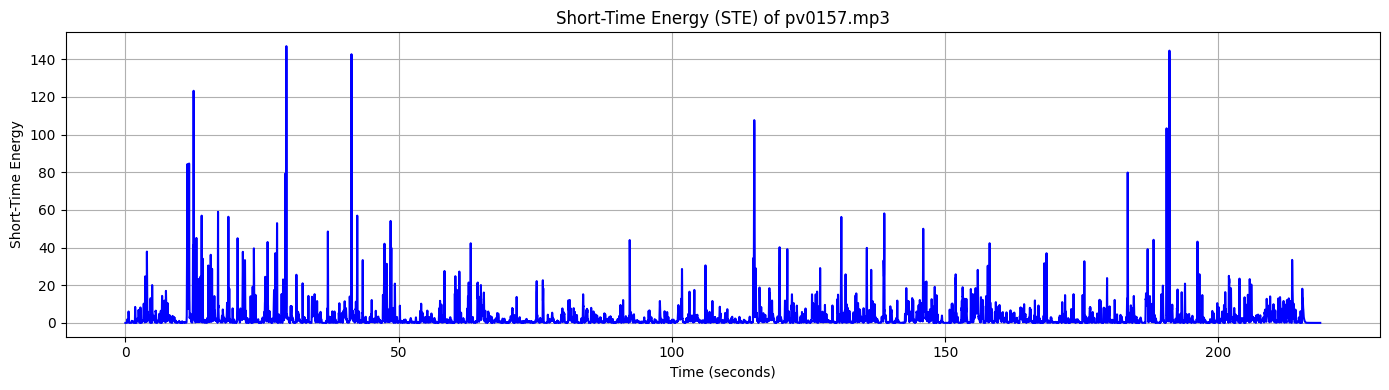

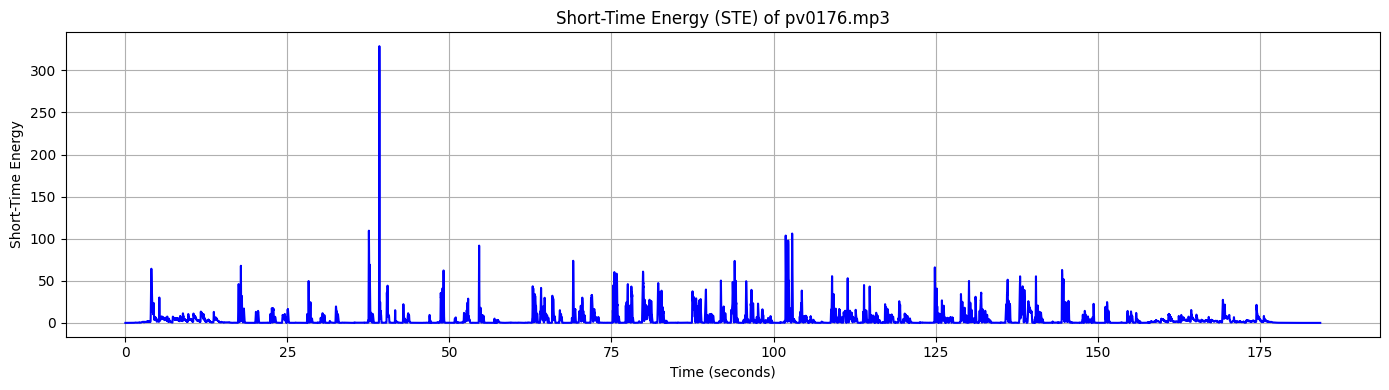

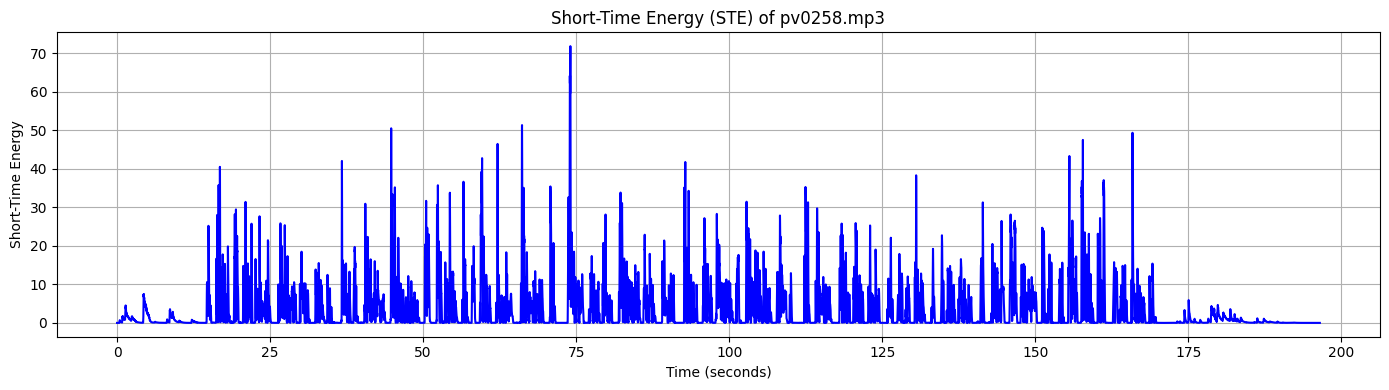

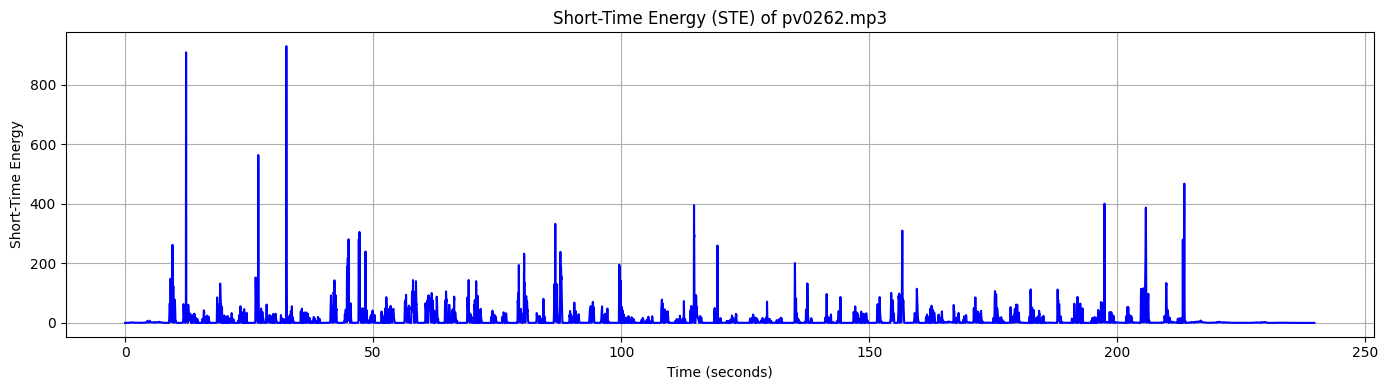

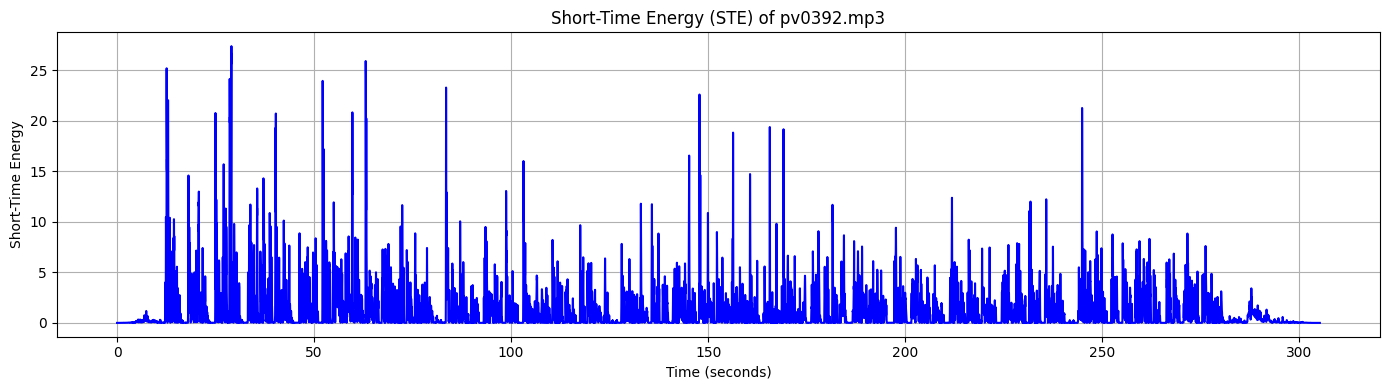

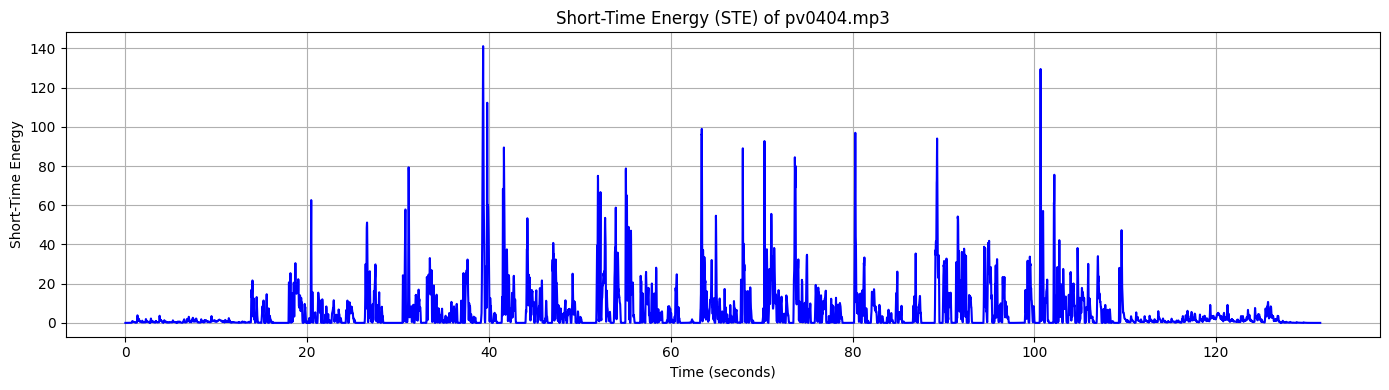

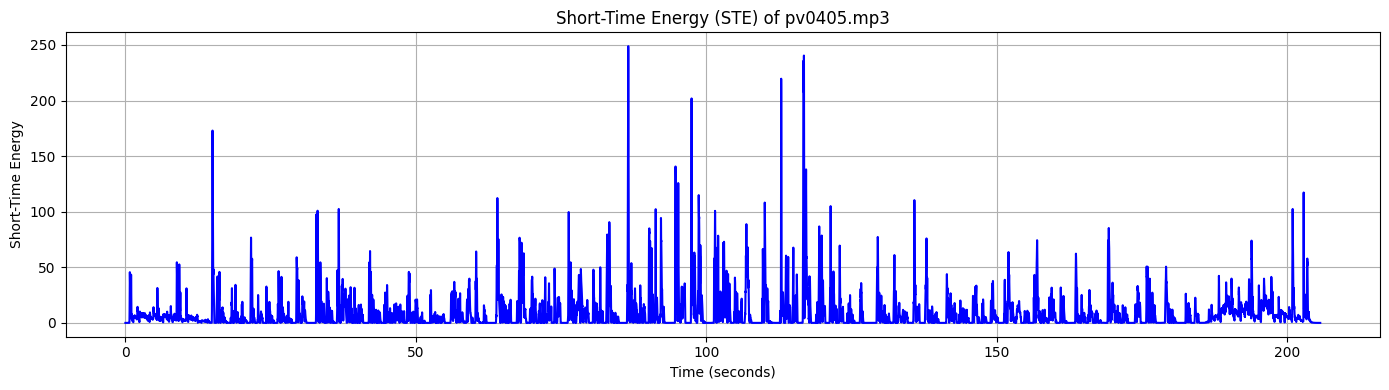

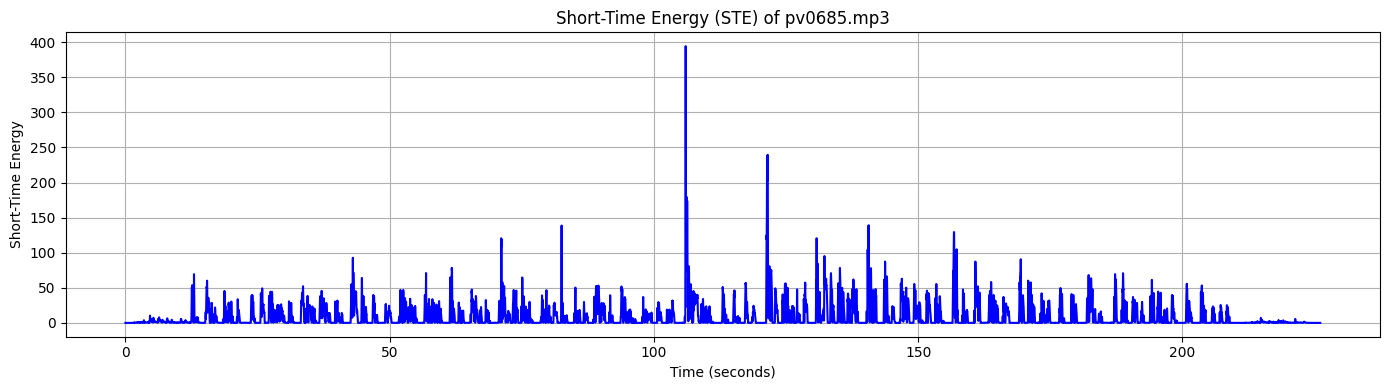

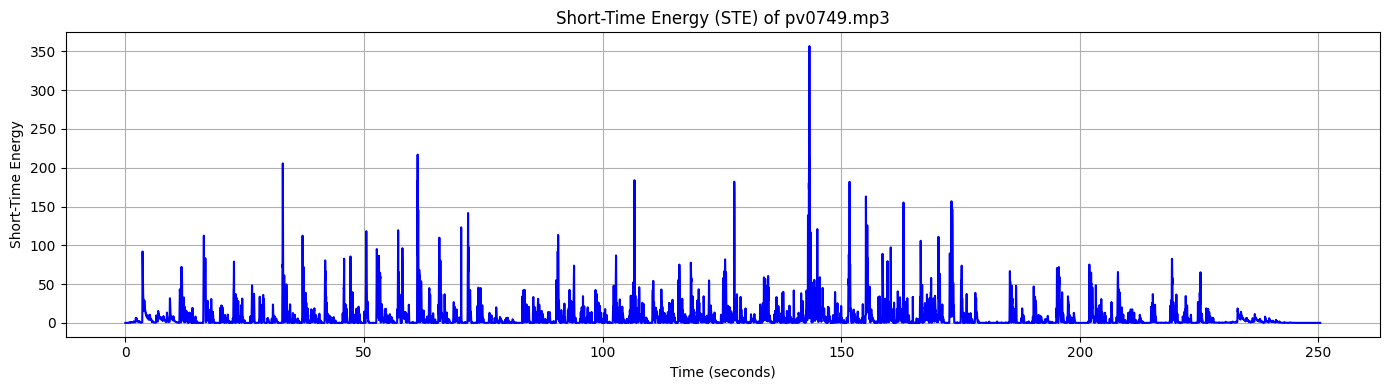

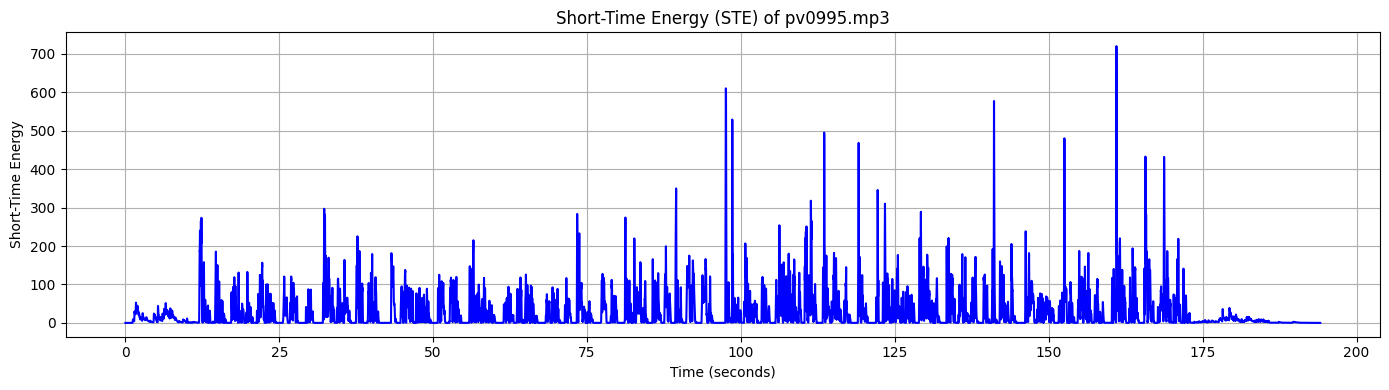

In [11]:
for pv in pv_id:
    sd_file = pv + ".mp3"
    quick_STE(sd_file)

# **Pitch Analysis**

*I computed the pitch contour of the story audio to serve as the basis for detecting intonation variations.*

In [12]:
def quick_pitch(sd, f0_min=50, f0_max=500, frame_length=2048, hop_length=512):
    # Load audio
    y, sr = librosa.load(sd, sr=None)

    # Extract fundamental frequency (F0) using YIN
    f0 = librosa.yin(y, fmin=f0_min, fmax=f0_max, sr=sr, frame_length=frame_length, hop_length=hop_length)

    # Generate time axis in seconds
    times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length)

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(times, f0, label='Pitch Contour', color='orange')
    plt.xlabel('Time (s)')
    plt.ylabel('Fundamental Frequency (Hz)')
    plt.title(f'Pitch Contour of {sd}')
    plt.grid(True)
    plt.legend()
    plt.show()

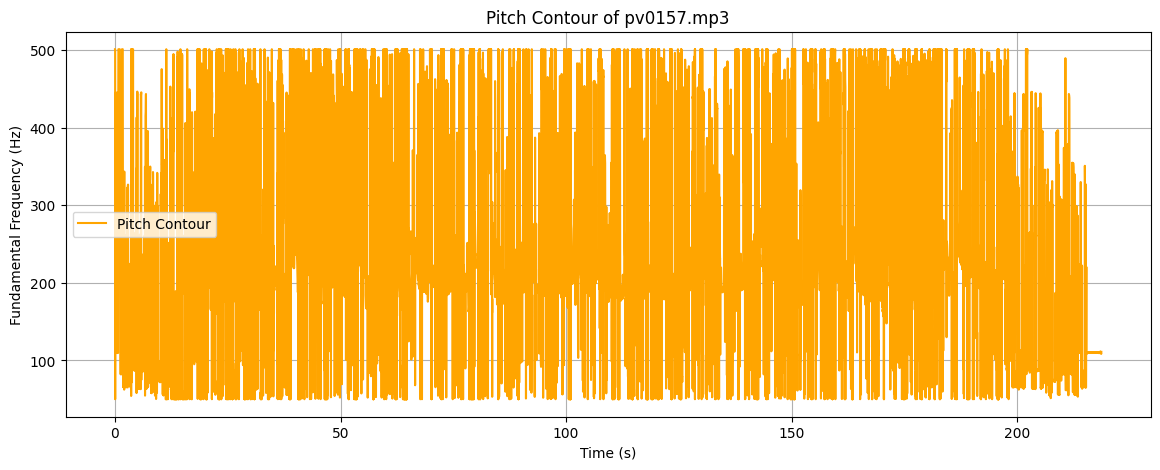

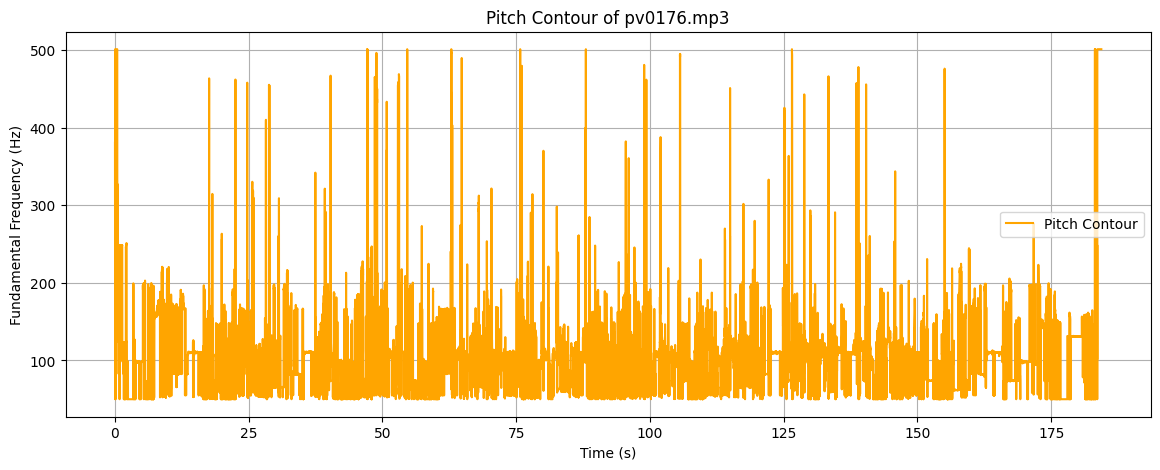

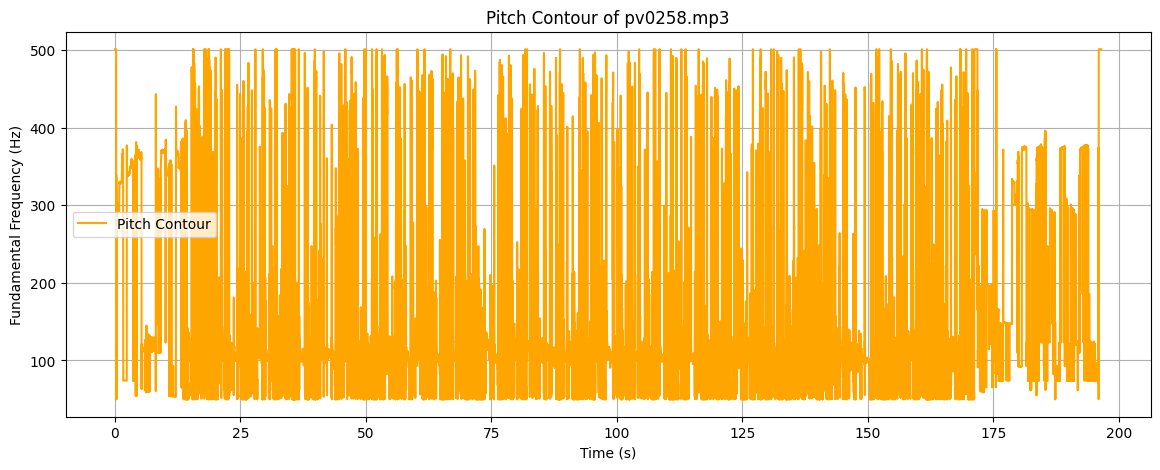

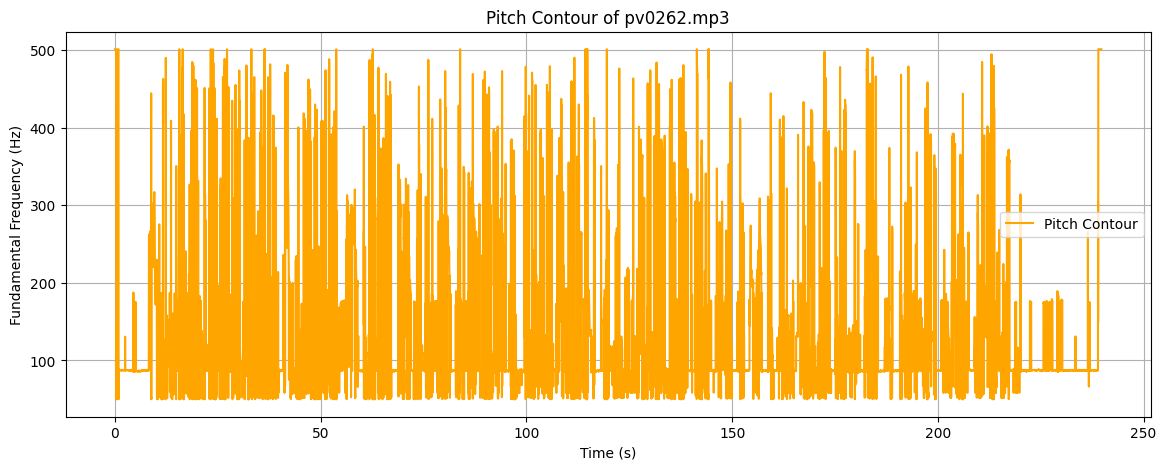

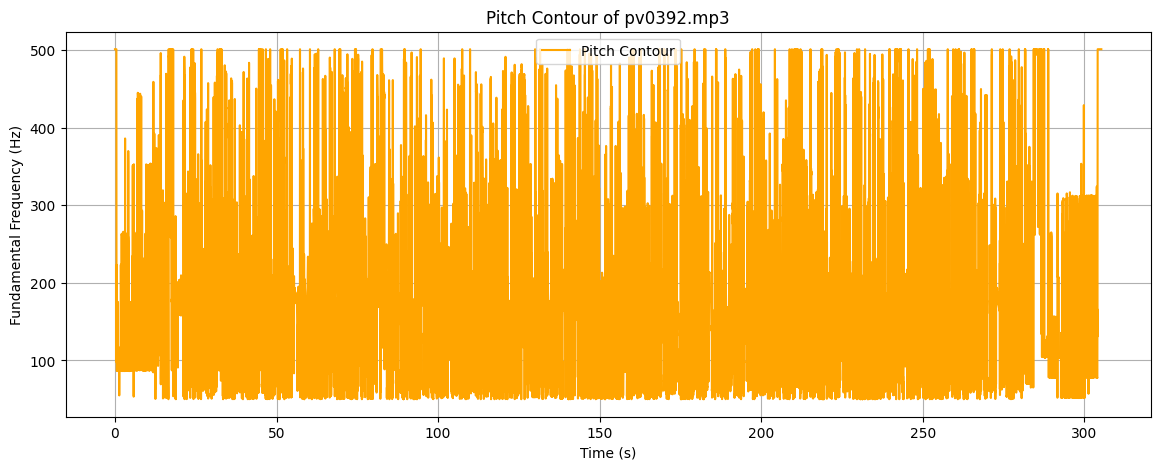

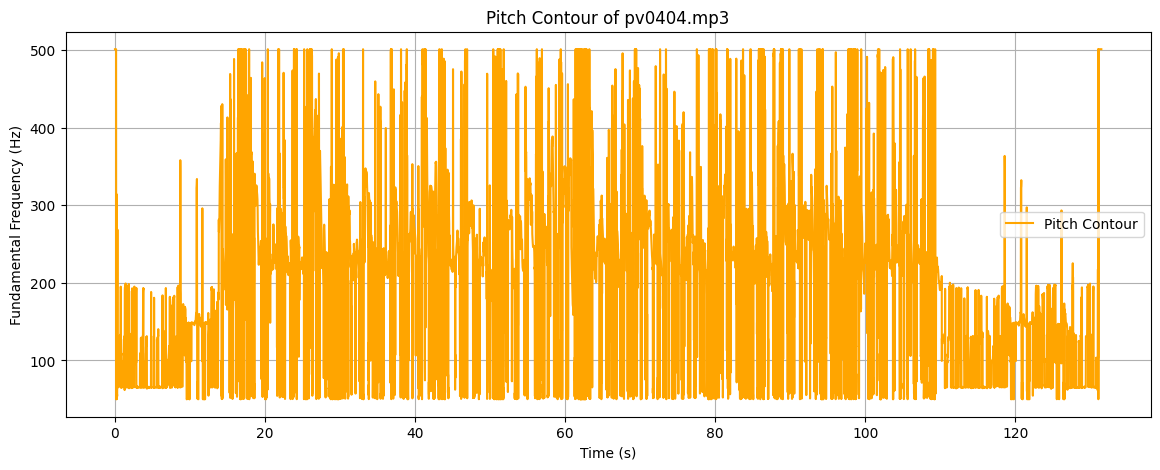

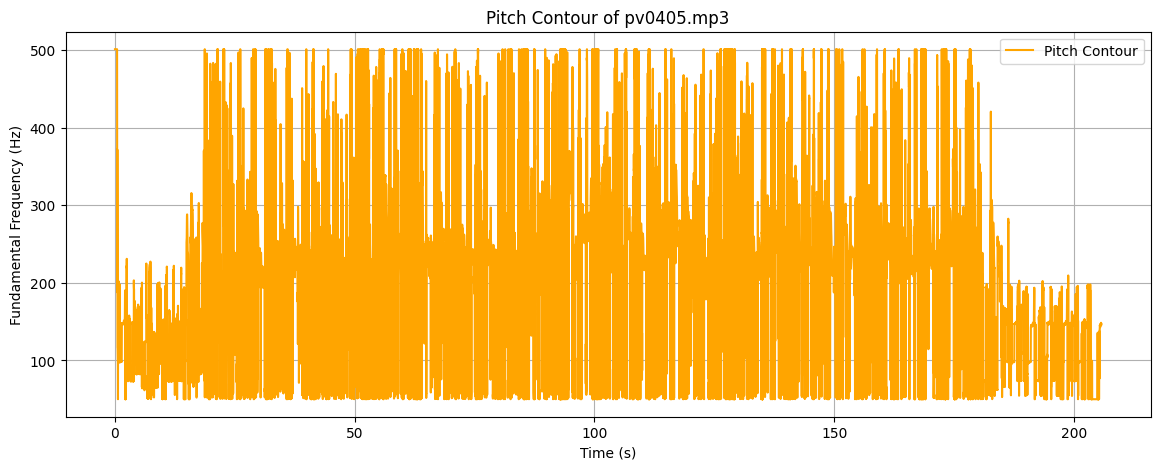

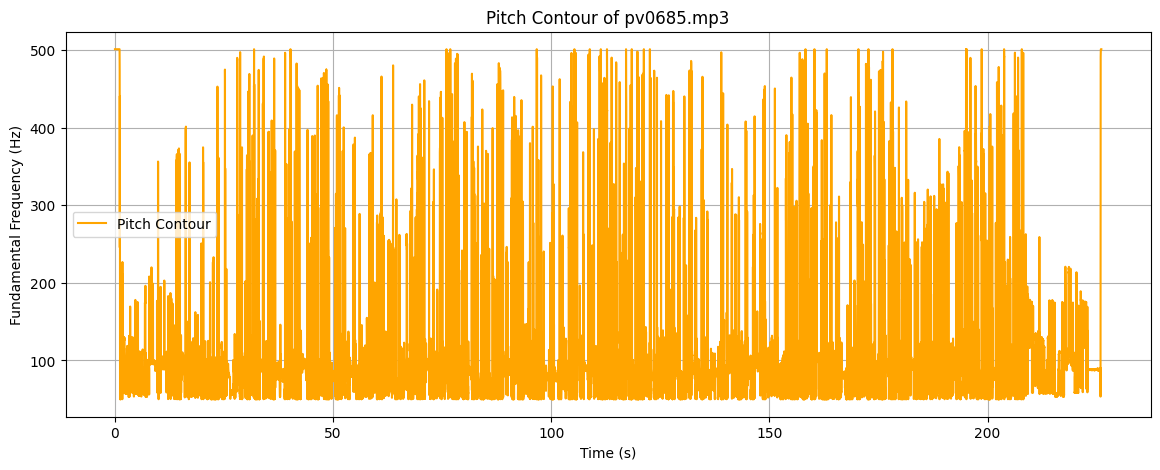

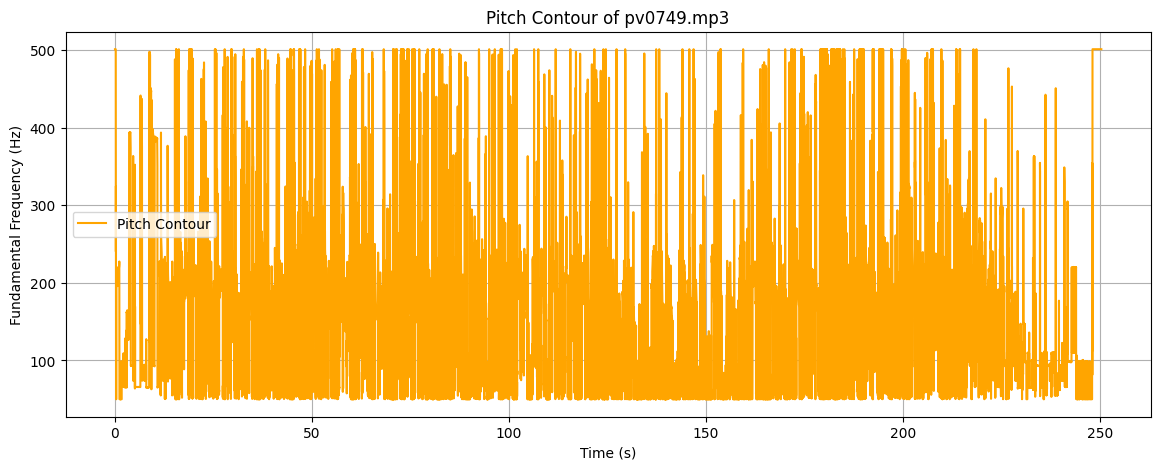

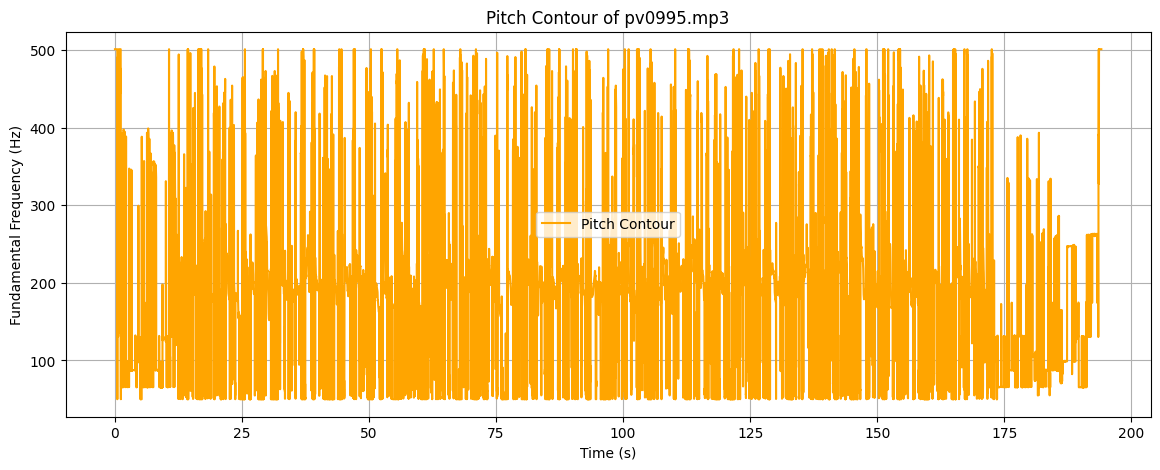

In [13]:
for pv in pv_id:
    sd_file = pv + ".mp3"
    quick_pitch(sd_file)

# **Overall Analysis**

*This section combines speech rate, TF-IDF, and other metrics to create visualizations.*

In [14]:
import string
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
class ASR_ResultAnalysis:
    def __init__(self,pkl):
        # Load Whisper transcription result from pickle file
        with open(pkl, "rb") as f:
            result = pickle.load(f)
            self.result = result

        #
        translator = str.maketrans('', '', string.punctuation)
        raw_word_list = [s['text'].lower().translate(translator).strip().split() for s in result['segments']]
        clean_text_list = [" ".join(words) for words in raw_word_list]
        origin_text = " ".join(clean_text_list)

        # Calculate
        word_counts = np.array([len(words) for words in raw_word_list])
        durations = np.array([seg['end'] - seg['start'] for seg in result['segments']])
        segment_starts = np.array([seg['start'] for seg in result['segments']])
        segment_ends = np.array([seg['end'] for seg in result['segments']])
        segment_rates = durations/ word_counts
        accumulate_word_counts = [sum(word_counts[:i+1]) for i in range(len(word_counts))]

        # Calculate approximate occurrence time for each word within its segment
        word_occurrence_time = []
        for i, word_l in enumerate(raw_word_list):
            rate = segment_rates[i]
            start = segment_starts[i]
            word_occurrence_time.extend([start + rate*(j+1) for j in range(len(word_l))])

        # Flatten the list of word lists into a single list of words
        flat_word_list = []
        for word_list in raw_word_list:
            flat_word_list.extend(word_list)

        # Initialize the vectorizer (optionally filter out English stop words)
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform([origin_text] + clean_text_list)
        feature_names = vectorizer.get_feature_names_out()

        # Convert the sparse TF-IDF matrix to a DataFrame
        df_tfidf = pd.DataFrame(
            tfidf_matrix.toarray(),
            columns=vectorizer.get_feature_names_out()
        )

        # Convert the first row of the TF-IDF DataFrame to a dictionary
        tfidf_dict = df_tfidf.iloc[0].to_dict()
        top = sorted(set(tfidf_dict.values()))[-2]

        # Create a DataFrame with words and their corresponding occurrence times
        df_words = pd.DataFrame({
            'Word': flat_word_list,
            'Occur_Time': word_occurrence_time
        })

        # Assign segment numbers and speech rates to each word based on segment info
        df_words['Segment'] = np.repeat(np.array(range(len(word_counts))) + 1 , word_counts)
        df_words['Rate'] = np.repeat(segment_rates , word_counts)
        df_words['tfidf_all'] = df_words['Word'].map(tfidf_dict)

        # For each word, get the TF-IDF value specific to its segment from the TF-IDF DataFrame; assign 0 if missing
        df_words['tfidf_seg'] = df_words.apply(lambda row: df_tfidf.at[row['Segment'], row['Word']] 
                                               if row['Word'] in df_tfidf.columns and row['Segment'] in df_tfidf.index 
                                               else 0, axis=1)

        # Fill any missing values with 0
        df_words = df_words.fillna(0)

        self.df = df_words

In [16]:
# Calculate and plot Short-Time Energy (STE) over time for an audio file.
def basic_STE(sd):
    # Load audio file
    y, sr = librosa.load(sd, sr=None)
    frame_length = 2048
    hop_length = 512

    # Compute Short-Time Energy (STE)
    energy = np.array([
        sum(abs(y[i:i+frame_length]**2))
        for i in range(0, len(y), hop_length)
    ])

    # Compute time axis in seconds
    times = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length)

    return times, energy

In [17]:
def basic_pitch(sd, f0_min=50, f0_max=500, frame_length=2048, hop_length=512):
    # Load audio
    y, sr = librosa.load(sd, sr=None)

    # Extract fundamental frequency (F0) using YIN
    f0 = librosa.yin(y, fmin=f0_min, fmax=f0_max, sr=sr, frame_length=frame_length, hop_length=hop_length)

    # Generate time axis in seconds
    times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length)

    return times, f0

In [18]:
# 
def quick_plot_overall(pv, title = 'Combined Normalized Metrics'):
    def normalize_arr(arr):
        arr_min = np.min(arr)
        arr_max = np.max(arr)
        return (arr - arr_min) / (arr_max - arr_min)

    # Calculate metrics
    ASR_result = ASR_ResultAnalysis(pv + ".pkl")
    df = ASR_result.df
    t1, energy = basic_STE(pv + ".mp3")
    t2, f0 = basic_pitch(pv + ".mp3")
    
    # Set figure size
    plt.figure(figsize=(24, 10))

    # Plot line chart of speech rate over time
    x = df['Occur_Time']
    y = normalize_arr(1/ df['Rate'])
    plt.plot(x, y, linestyle='-.', color='red', label='Speech Rate')

    # Plot line chart of STE over time
    x = t1
    y = normalize_arr(energy)
    plt.plot(x, y, linestyle='-', color='blue', label='STE')

    

    x = t2
    y = normalize_arr(f0)
    plt.plot(x, y, label='Pitch Contour', color='orange', alpha=0.3)

    # Plot Key Words with high TF-IDF values
    threshold = 0.3
    x = df['Occur_Time']
    y = normalize_arr(df['tfidf_all'])
    scatter = plt.scatter(x, y, c=y, cmap='viridis', s=50)
    plt.colorbar(scatter, label='TF-IDF value')
    for i, row in df.iterrows():
        if y[i] > threshold:
            plt.text(
                row['Occur_Time'] + 0.05,
                y[i] + 0.01,
                row['Word'],
                fontsize=9,
                rotation=45
            )

    # Add title and axis labels with increased font size
    plt.title(title, fontsize=16)
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Normalized Values', fontsize=14)

    # Display the plot
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

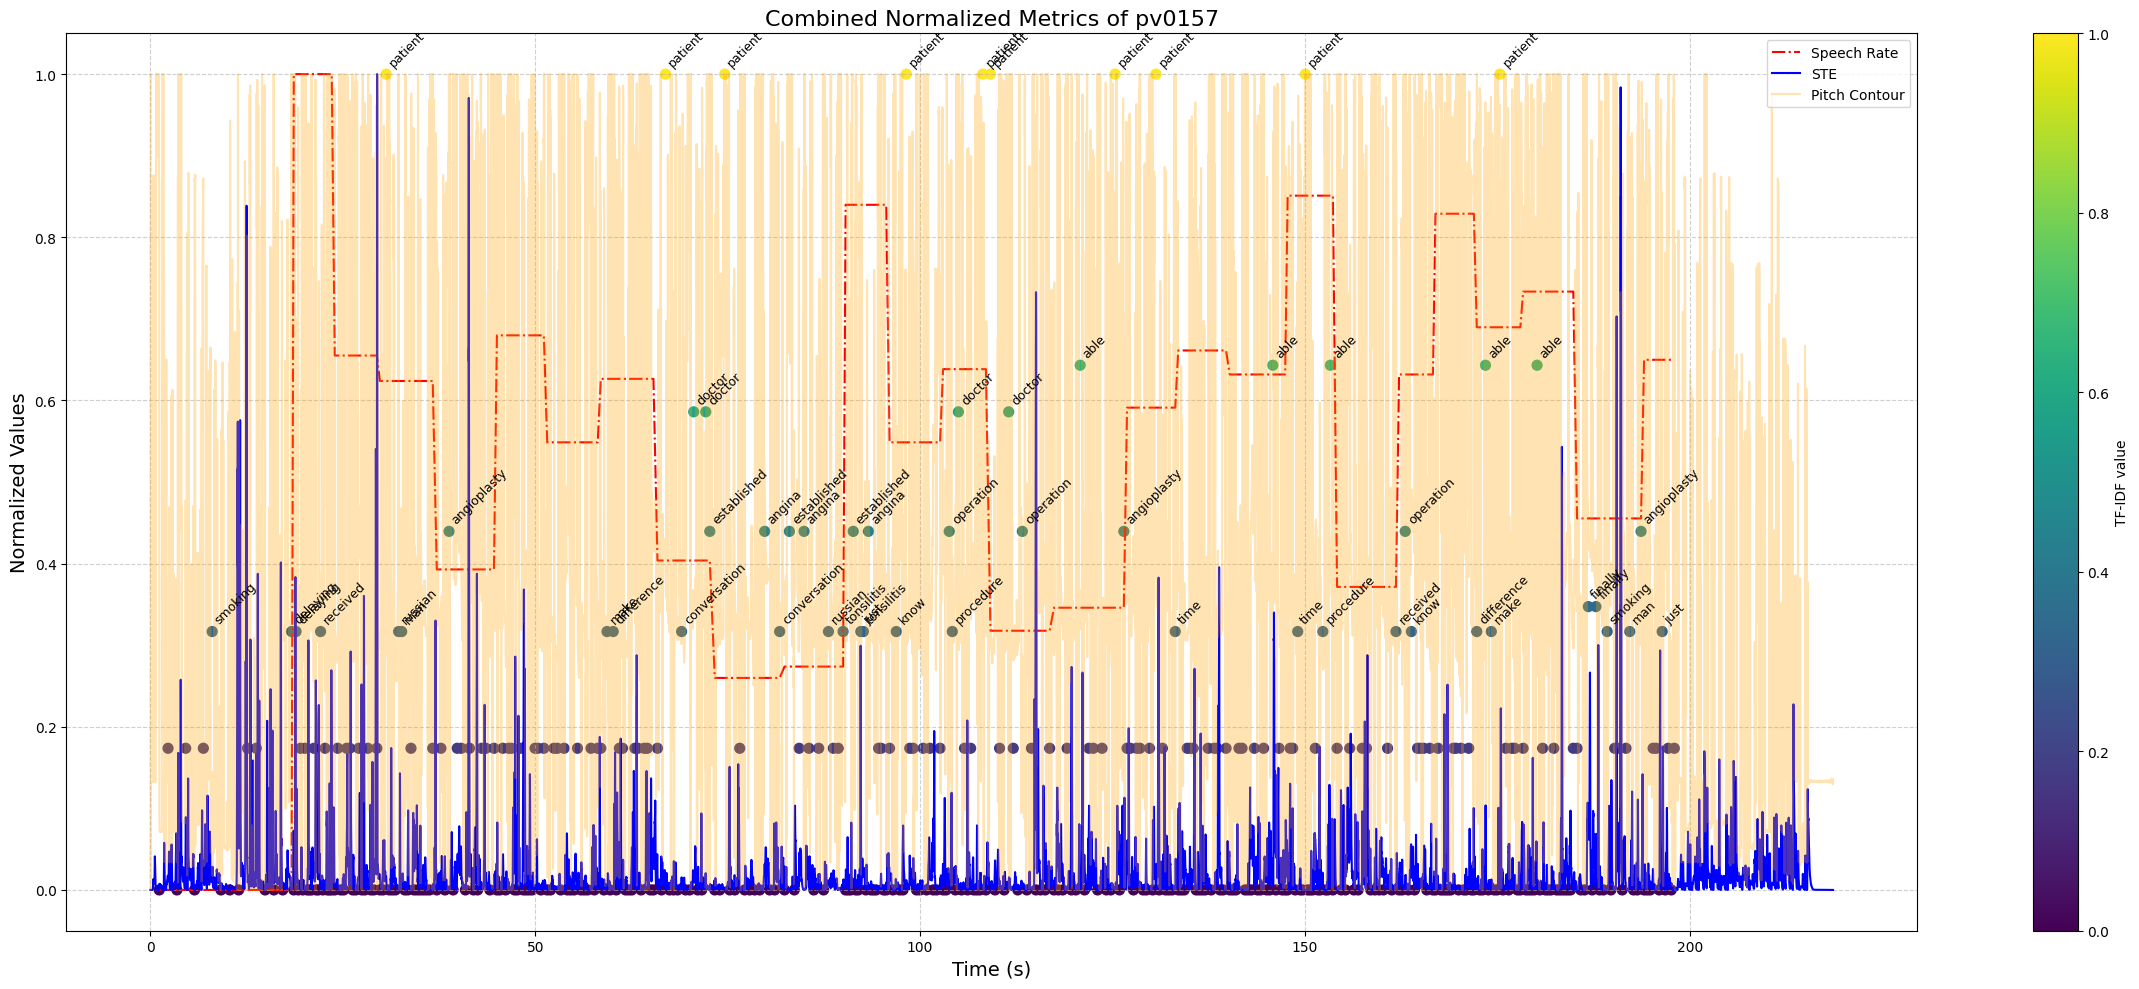

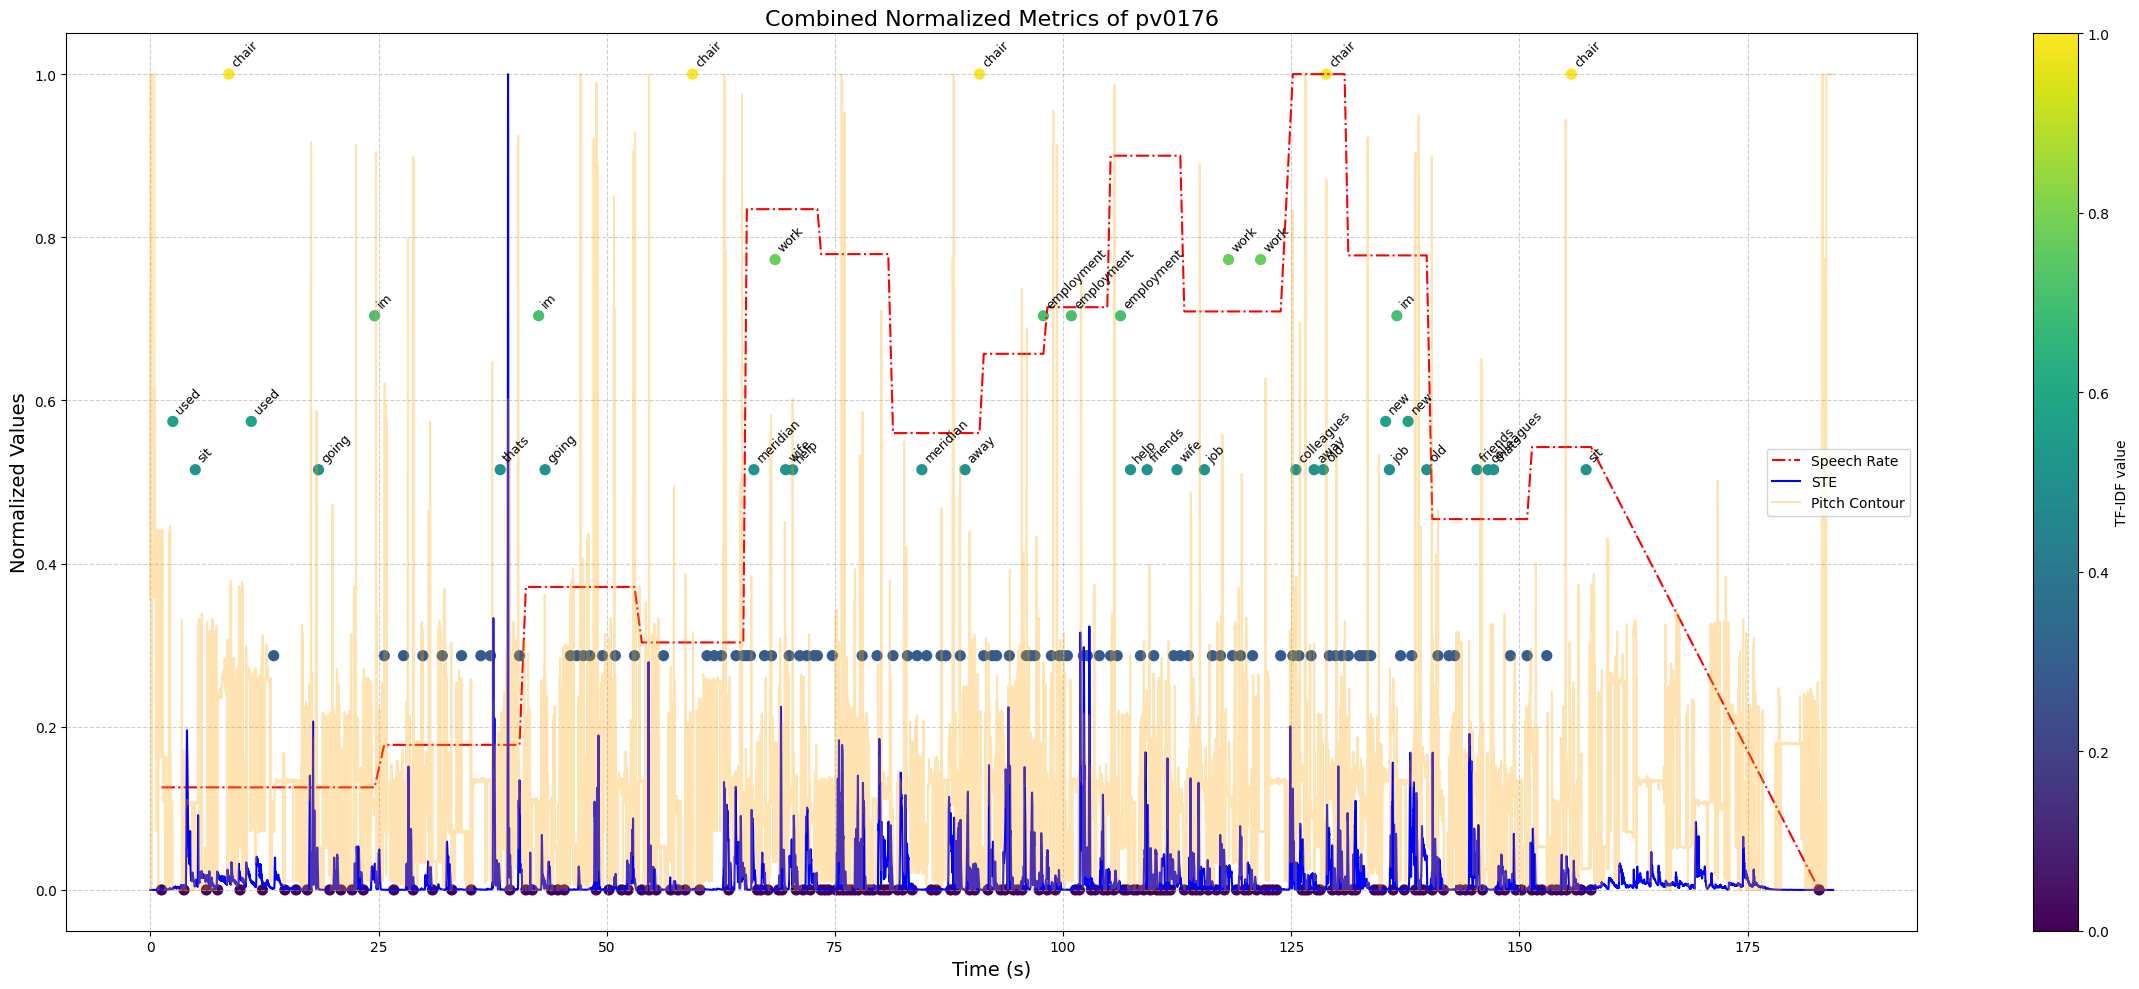

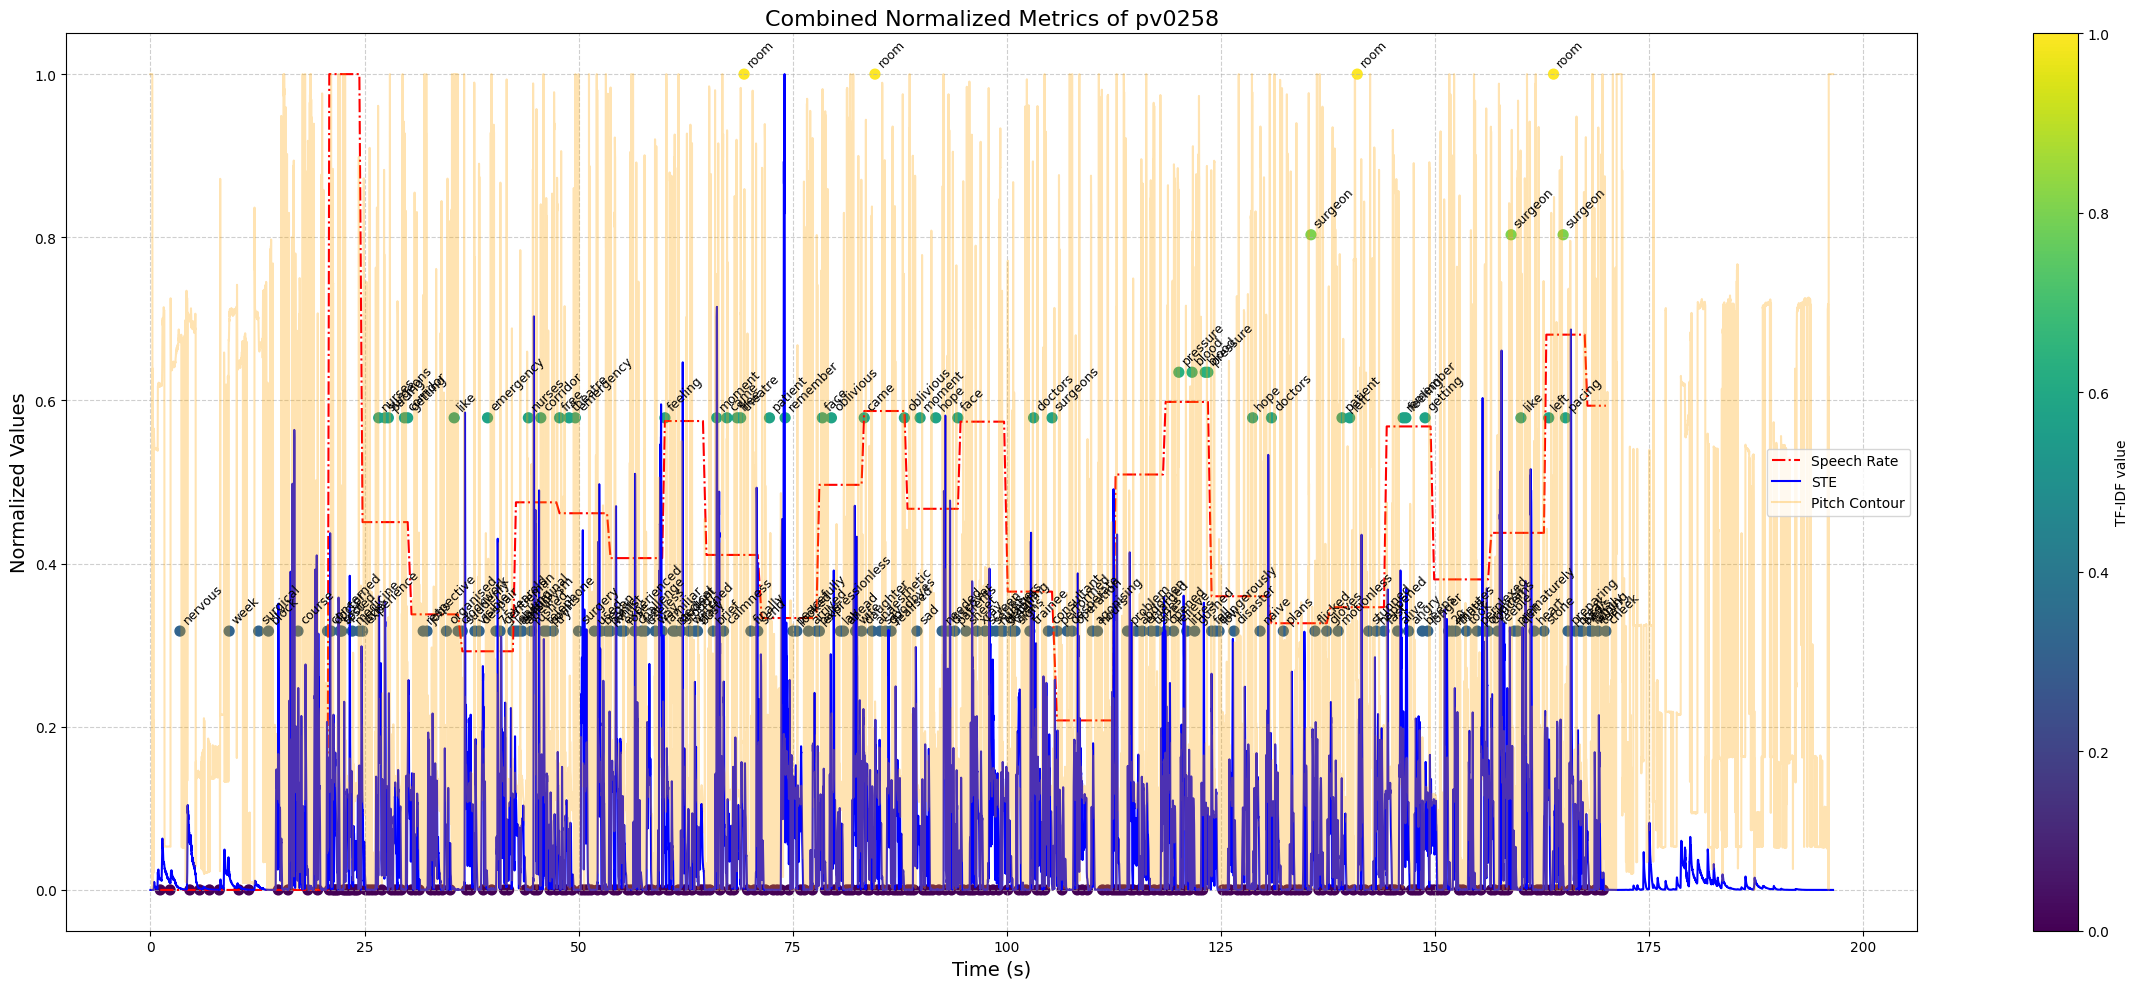

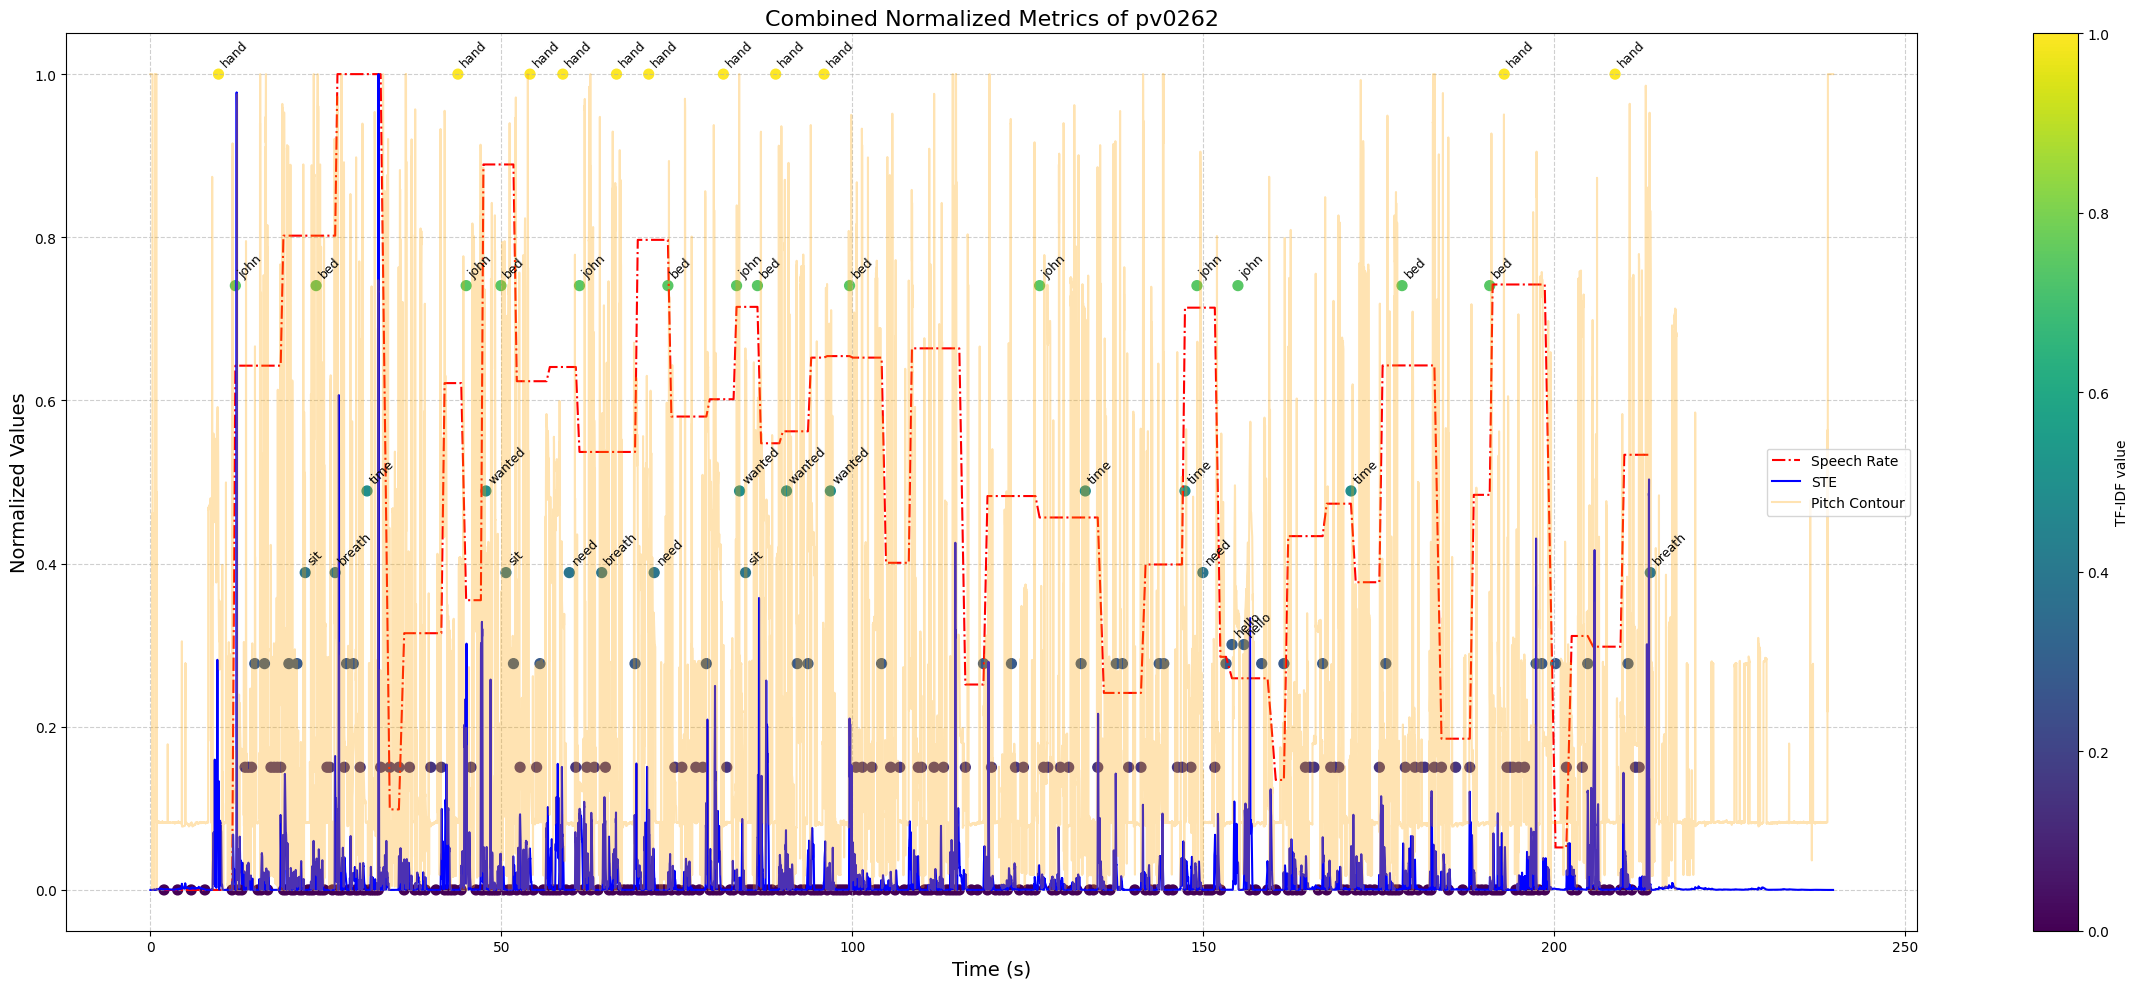

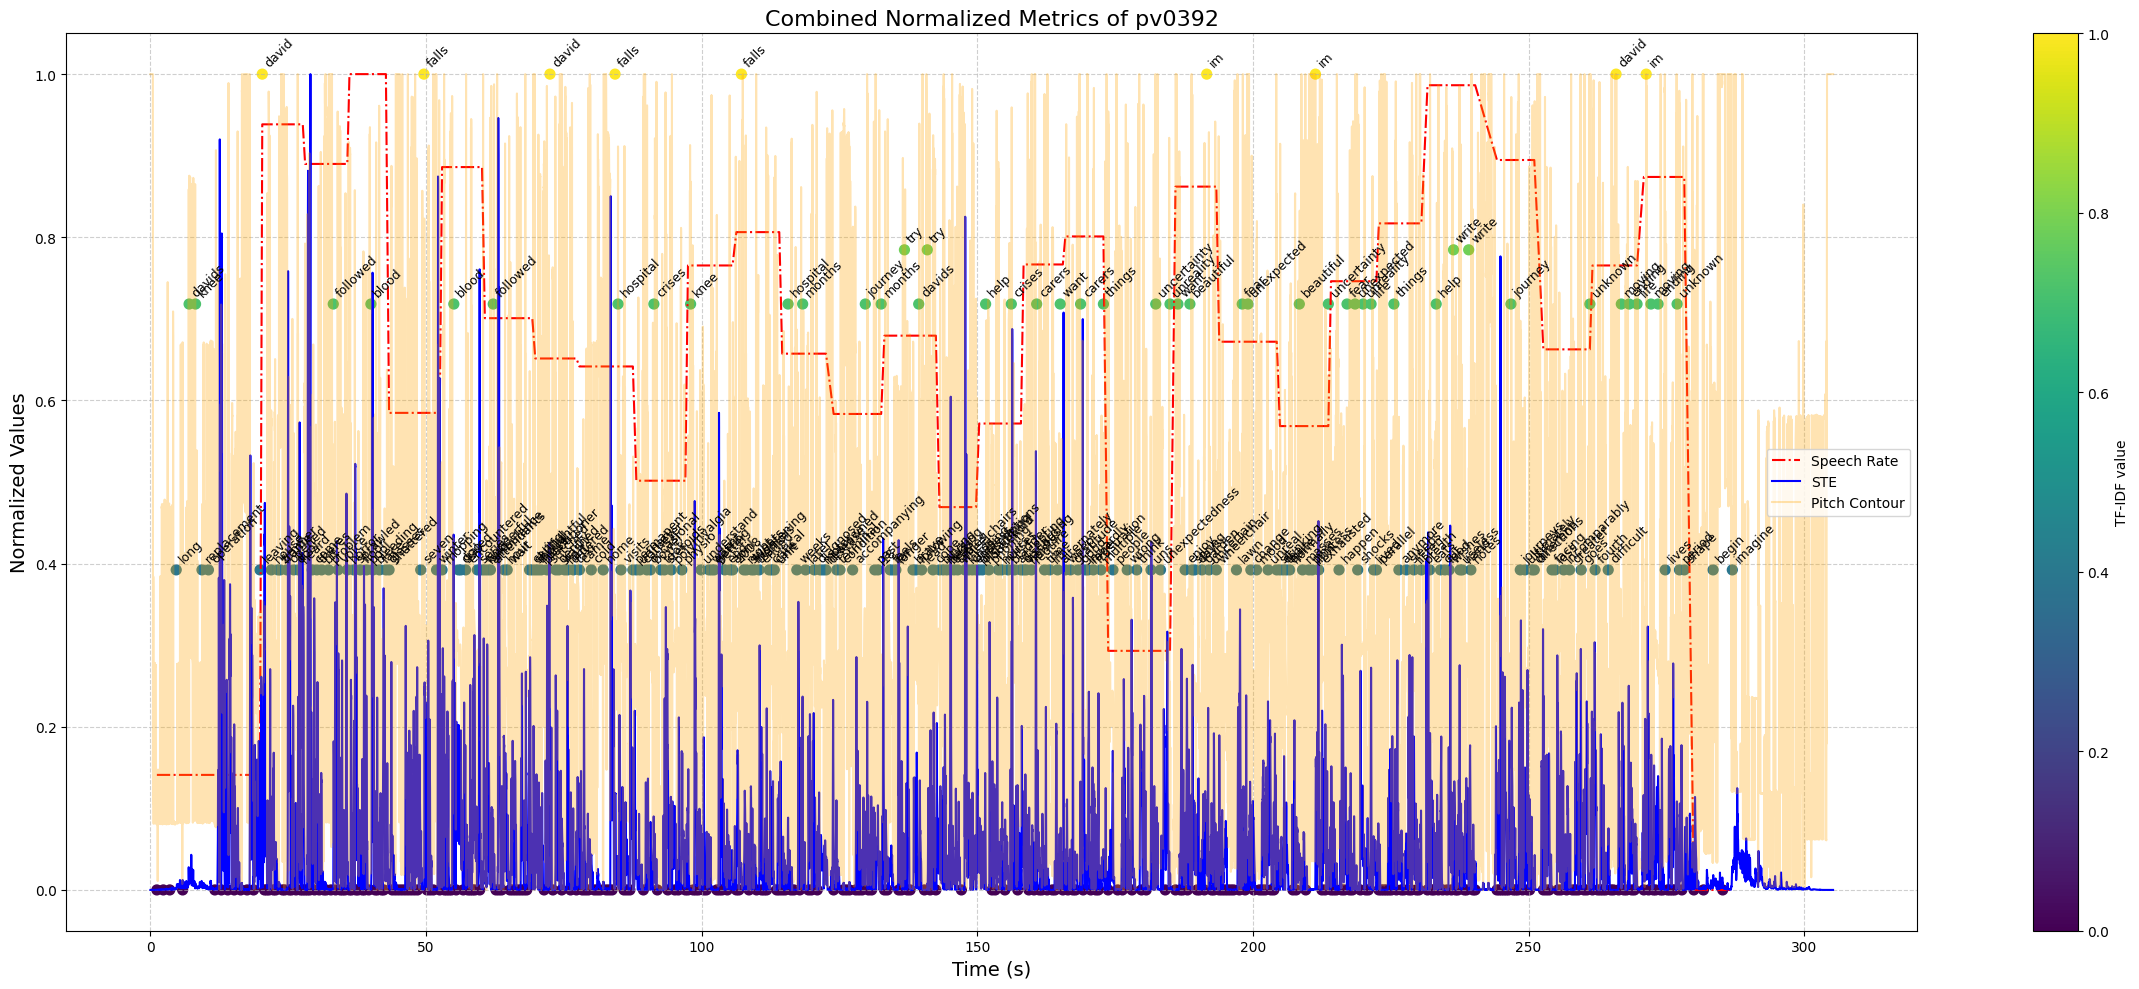

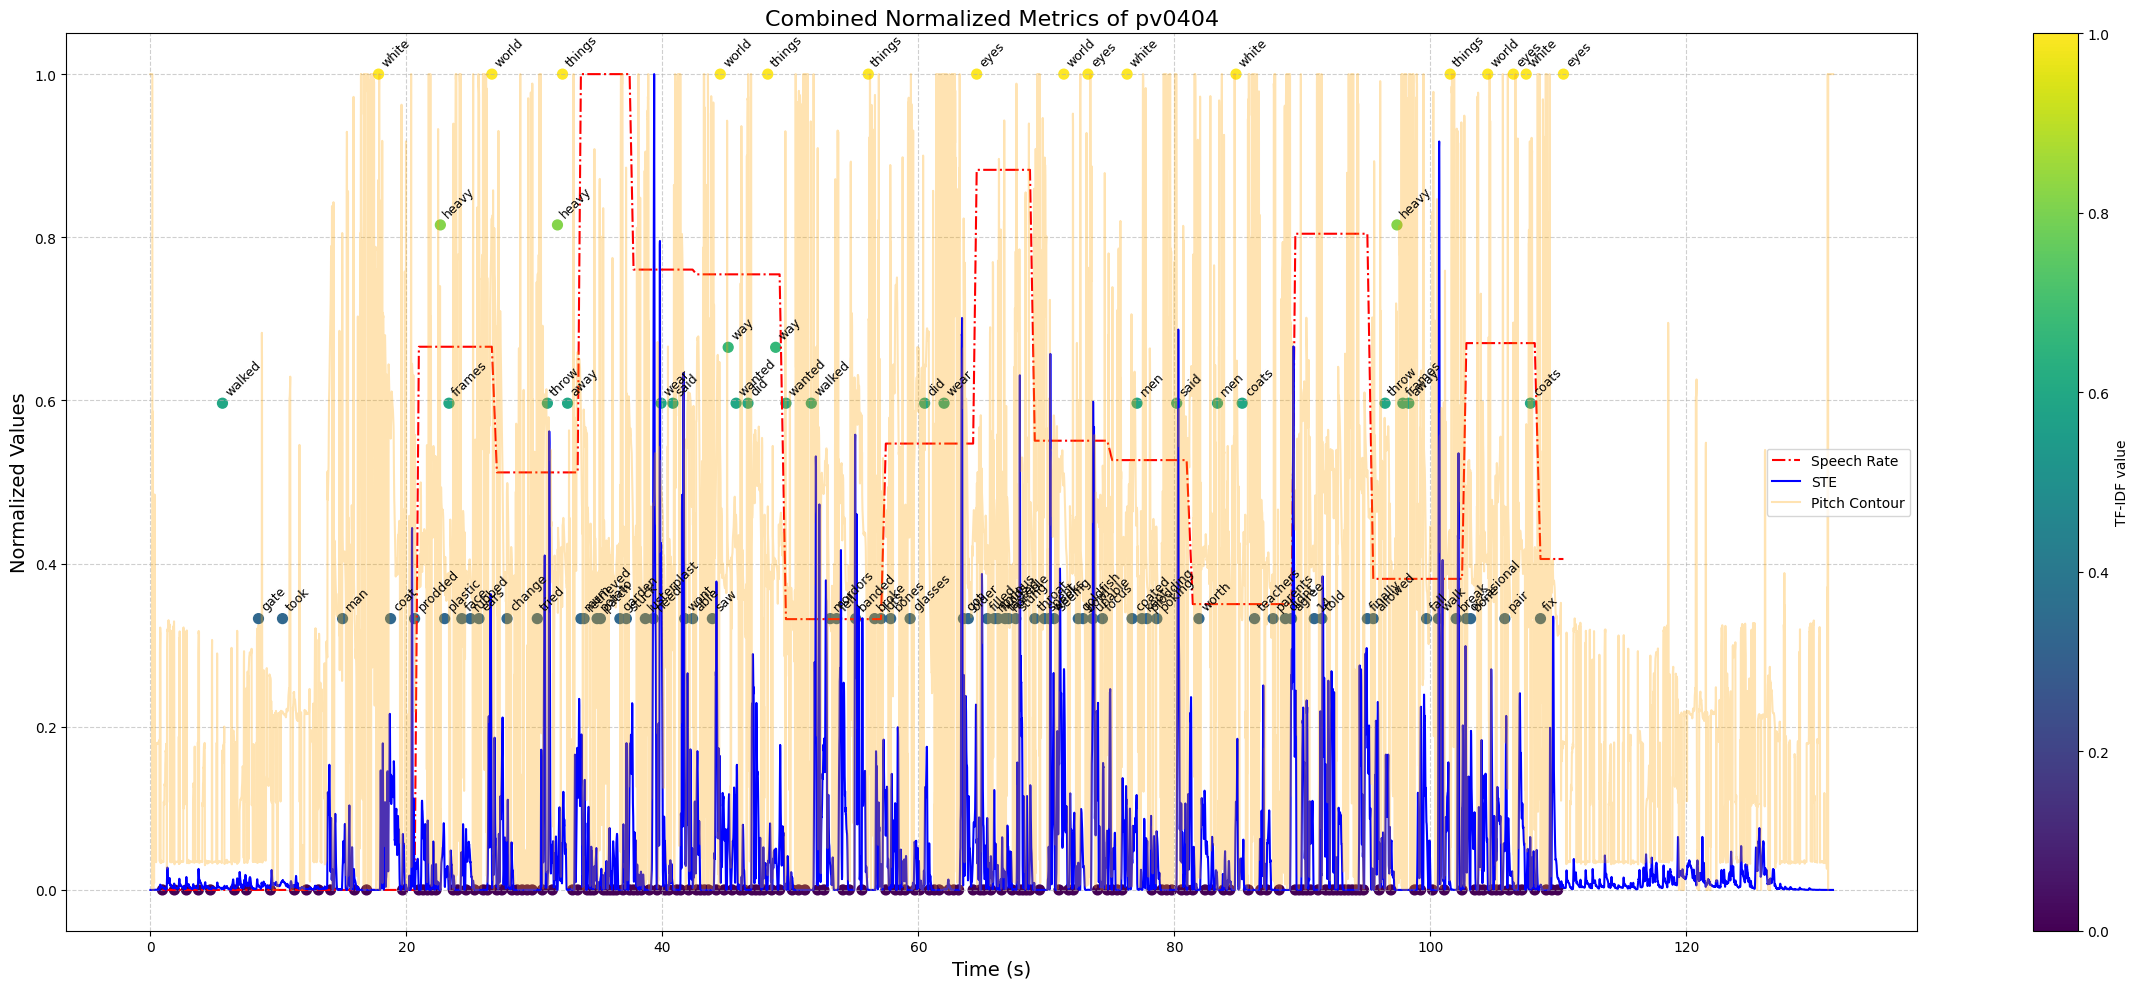

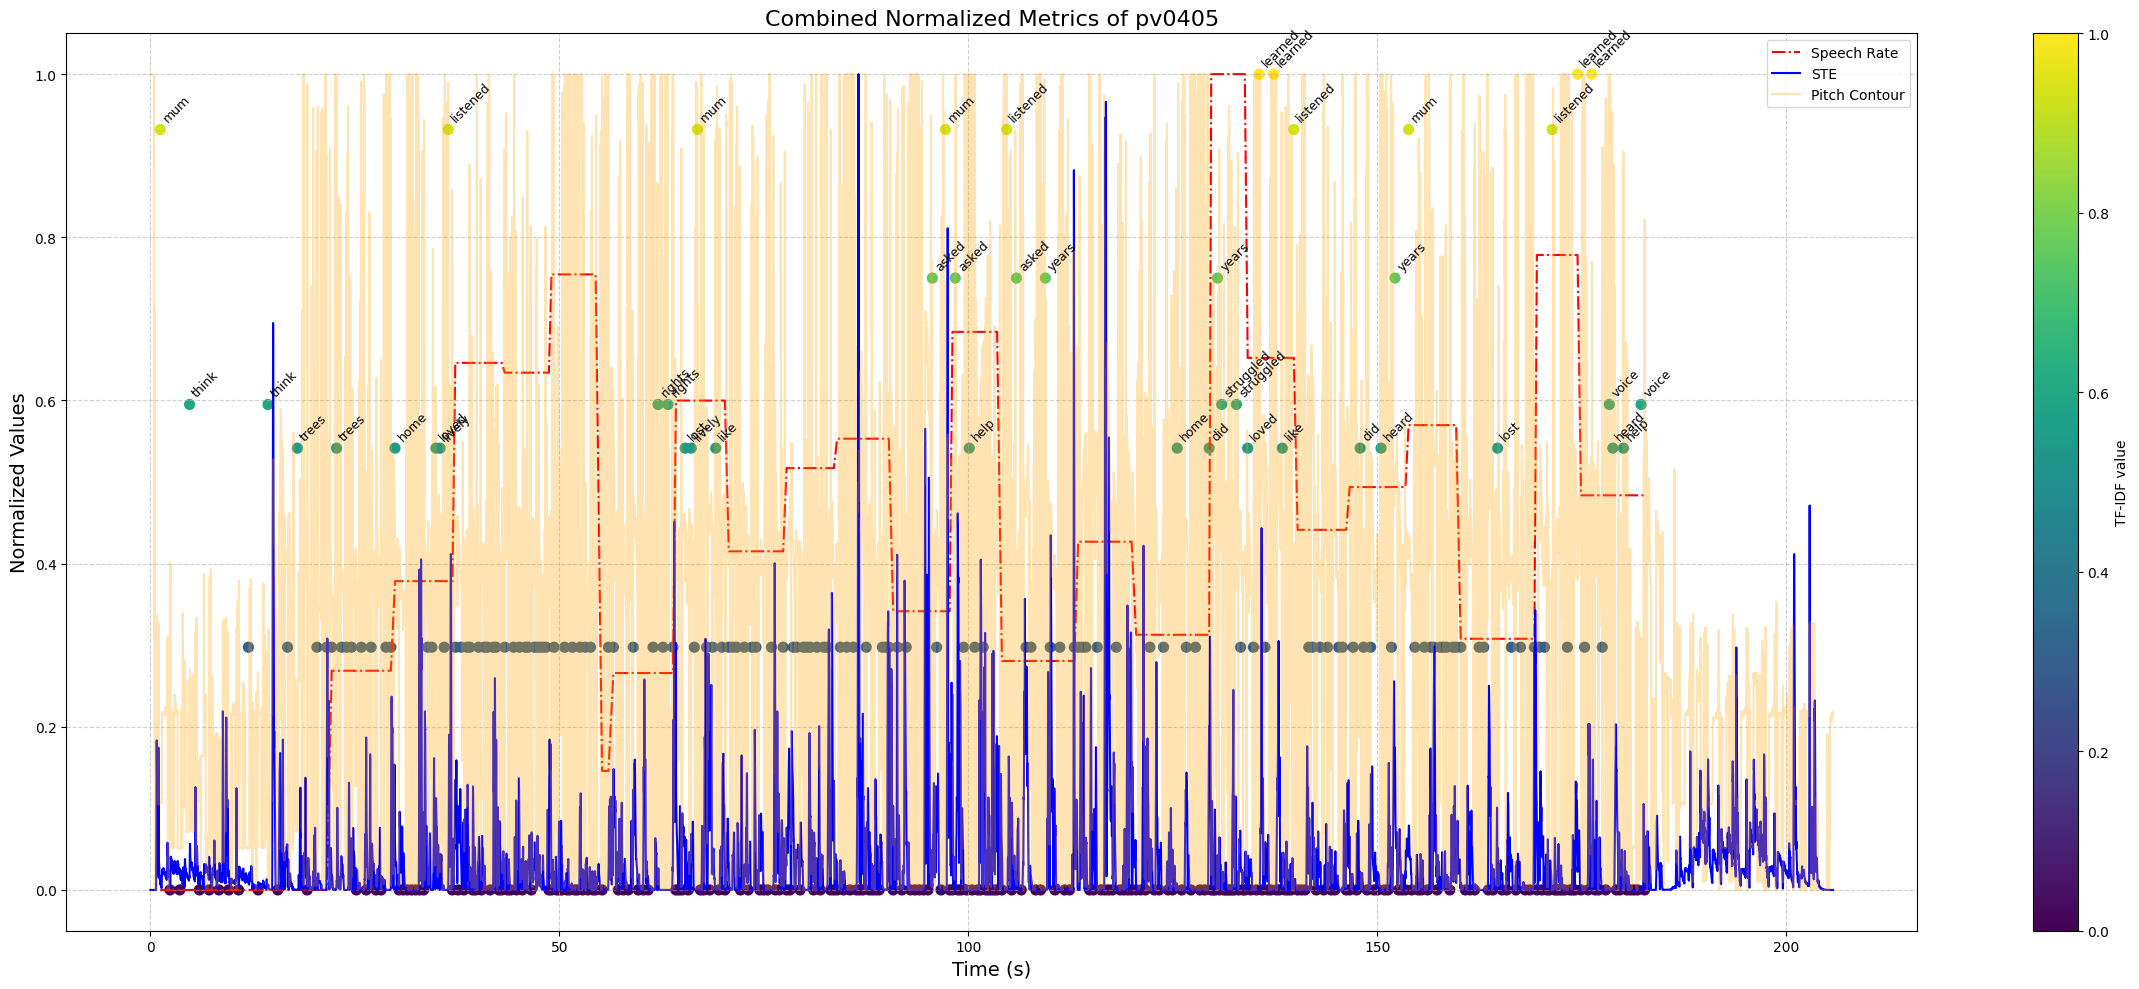

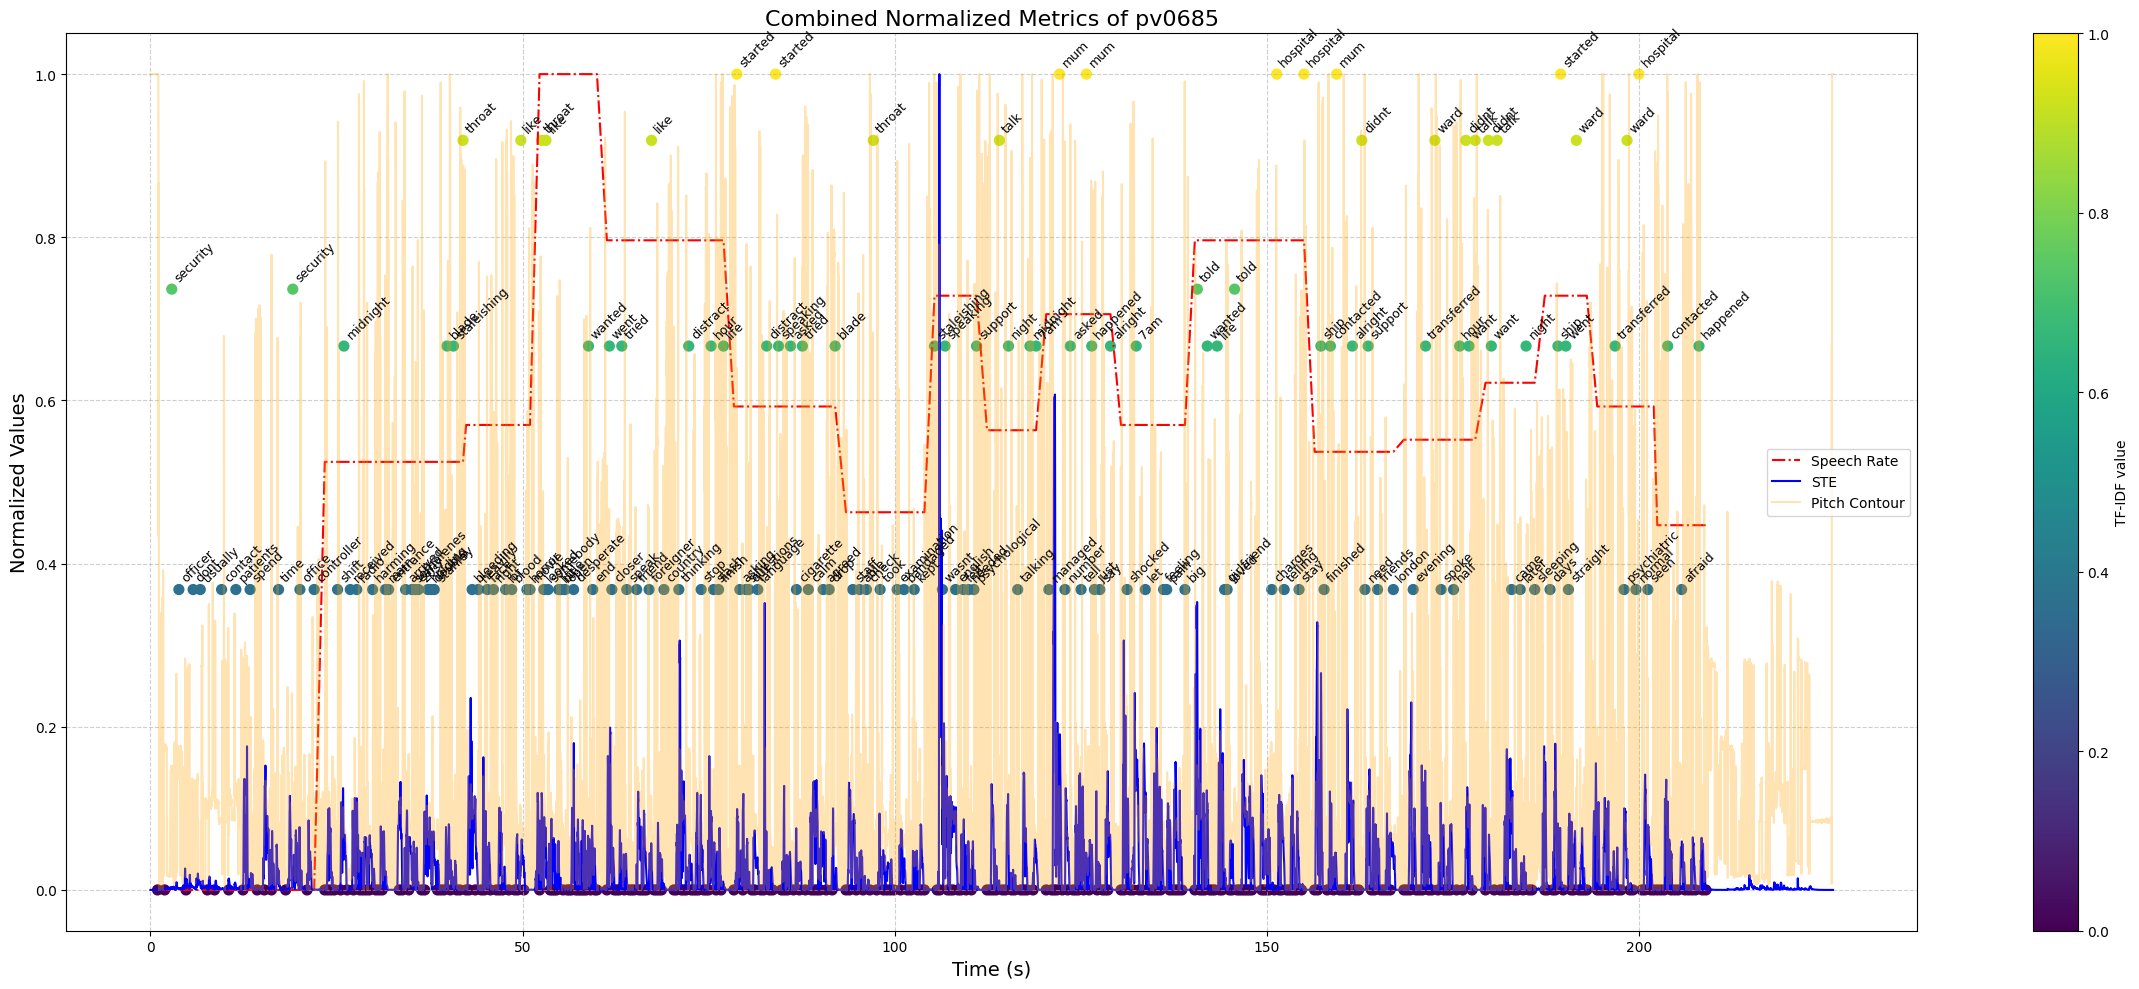

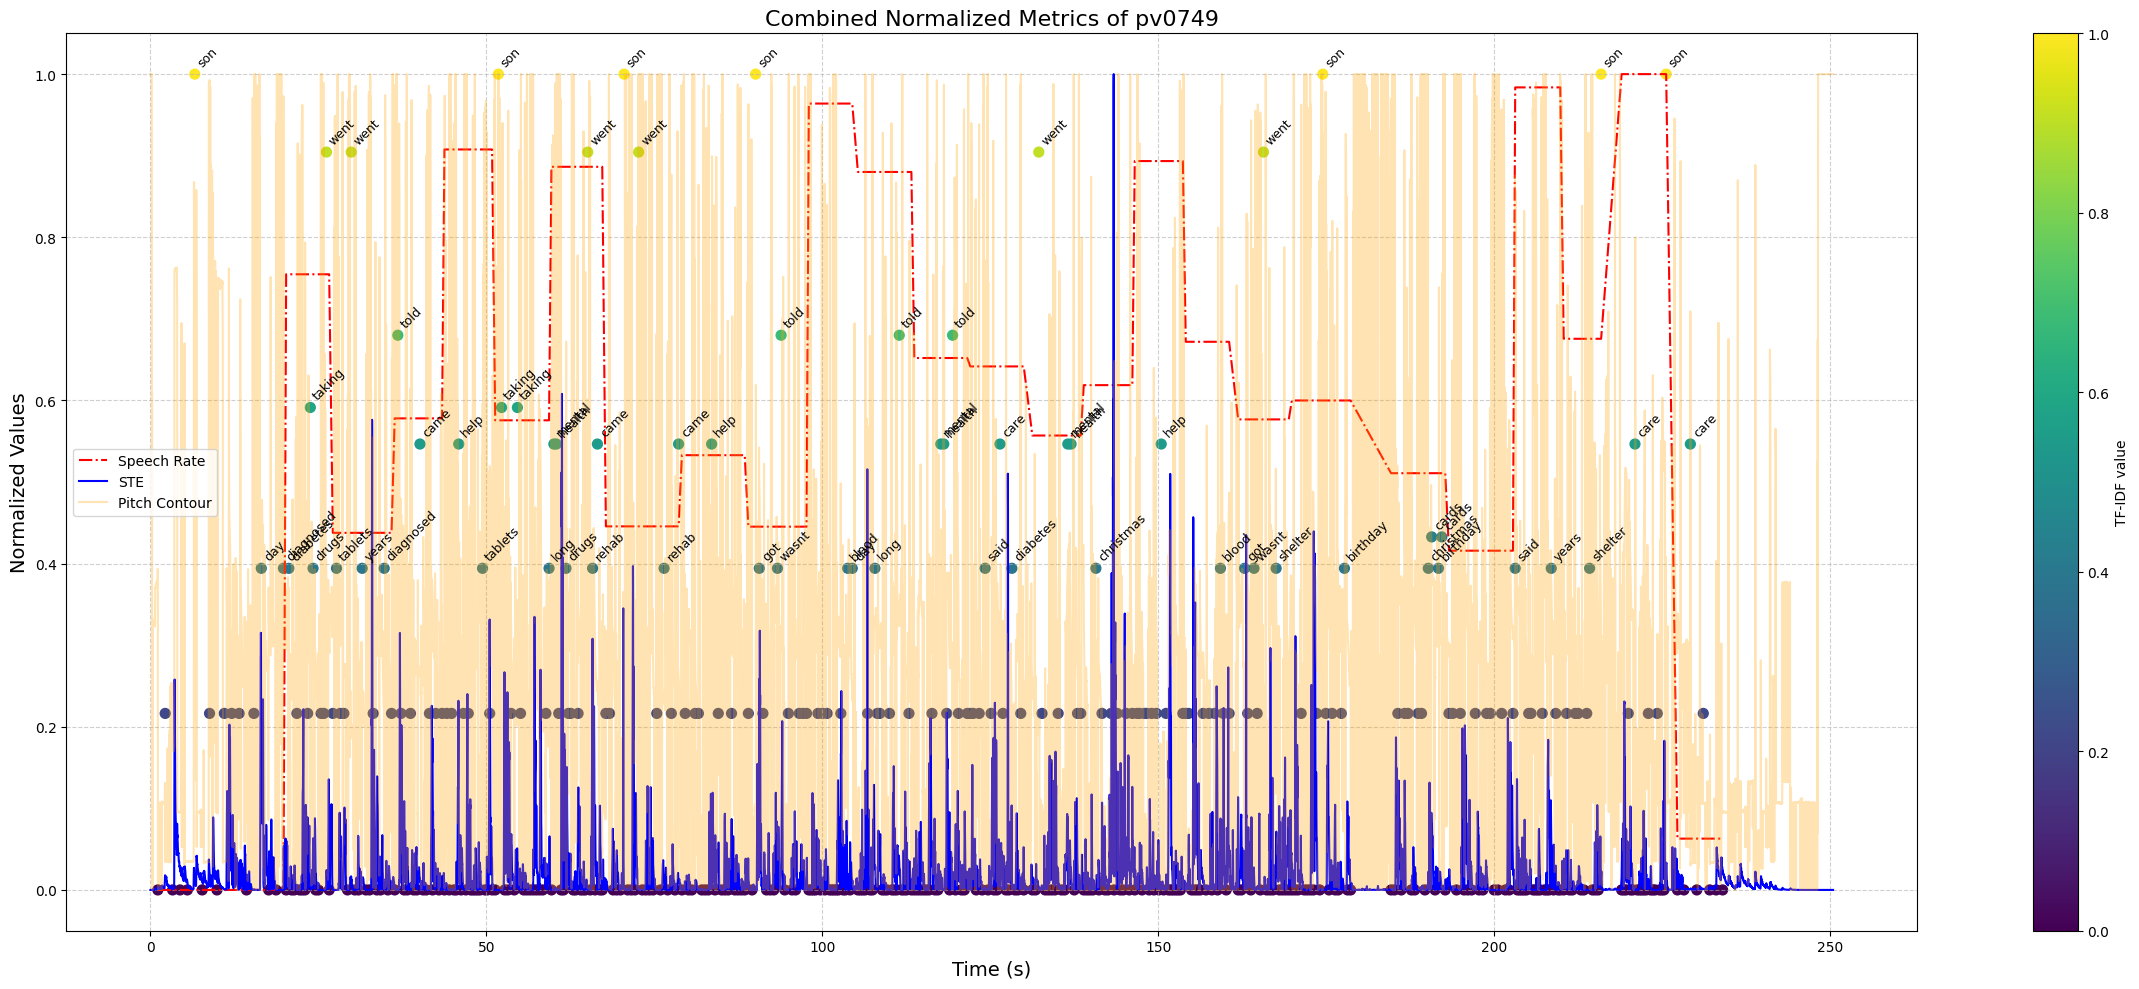

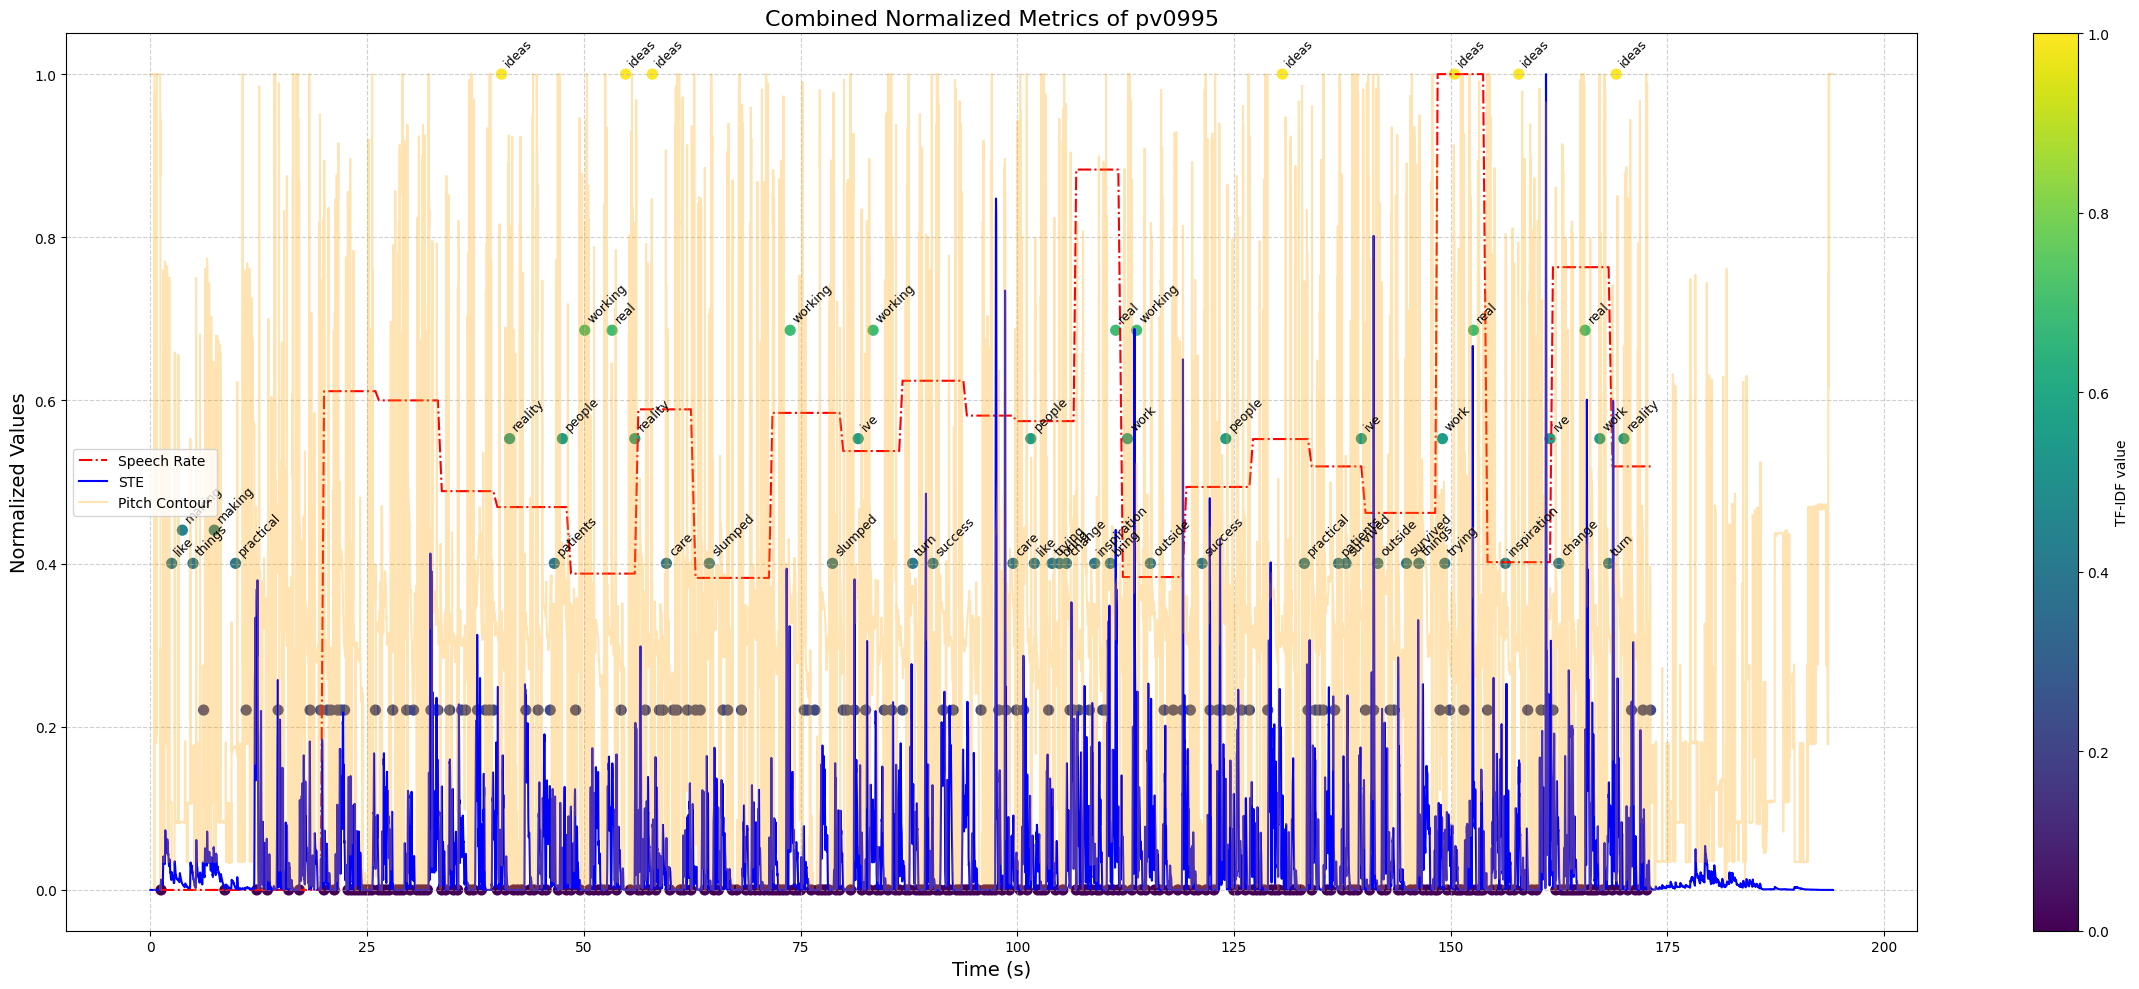

In [19]:
for pv in pv_id:
    quick_plot_overall(pv, f'Combined Normalized Metrics of {pv}')